In [1]:
# Install required packages
!pip install scikeras
!pip install keras

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score
from scikeras.wrappers import KerasClassifier
from keras.models import Sequential, Model
from keras.layers import Input, Dense
from keras.optimizers import Adam
import joblib

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Load dataset
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/CustomerChurn_dataset.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [4]:
df.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


In [13]:
# Select relevant features
relevant_features = ['TotalCharges', 'MonthlyCharges', 'tenure', 'SeniorCitizen', 'Partner', 'Dependents', 'Contract', 'Churn']
df_relevant = df[relevant_features]

# Define features (X) and target variable (y)
X = df_relevant.drop('Churn', axis=1)
y = df_relevant['Churn']



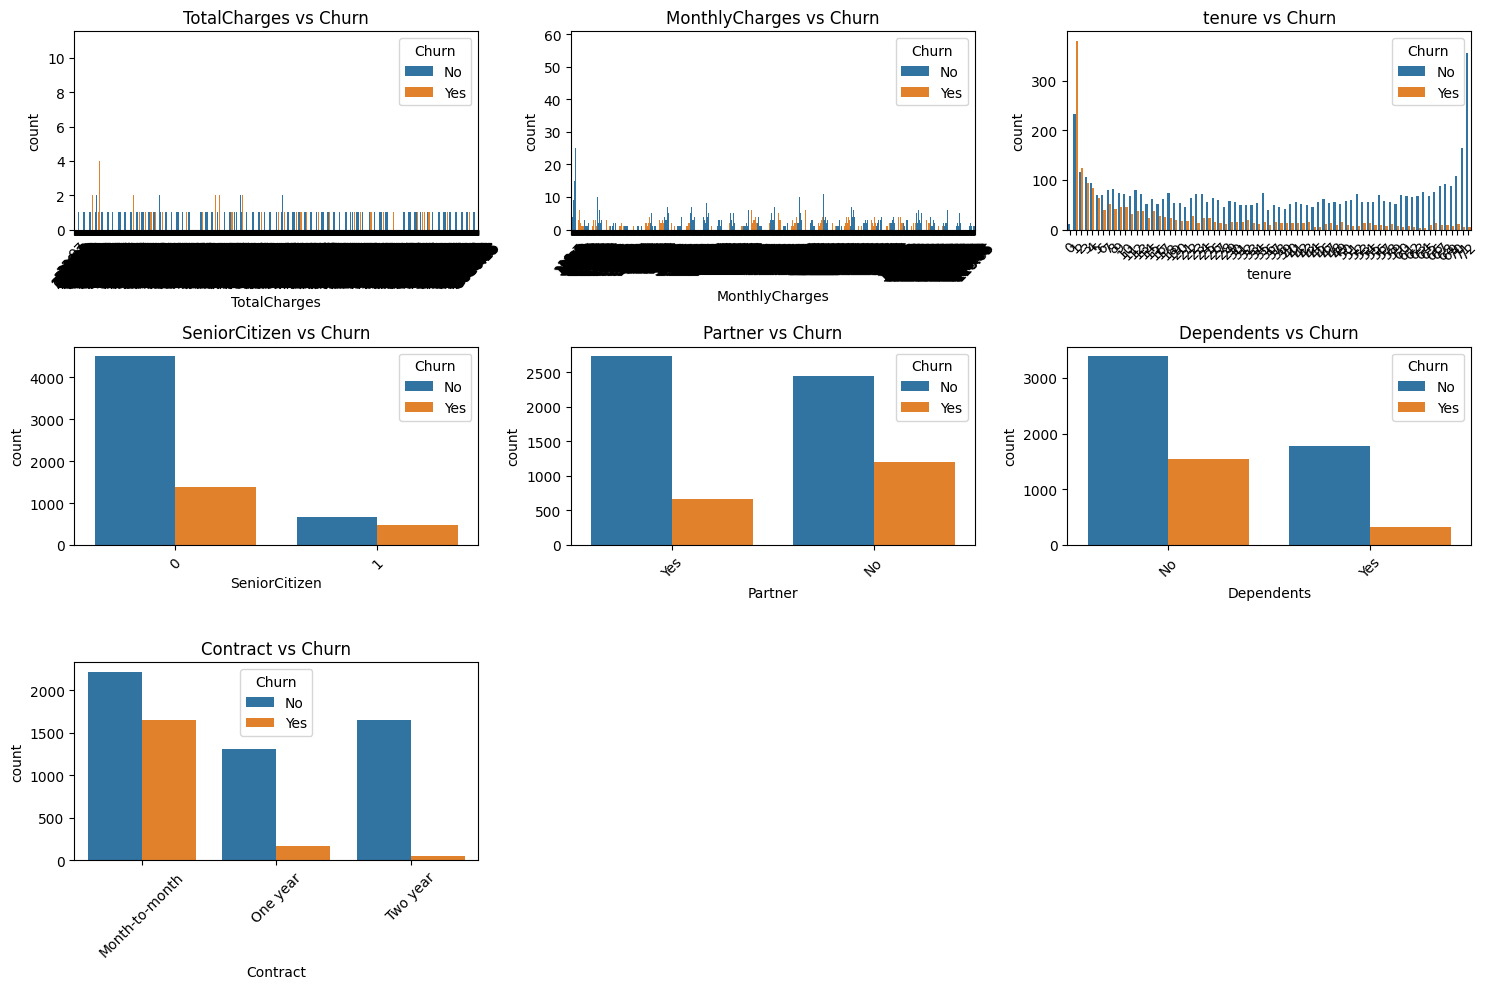

In [14]:
# Visualize feature distributions
plt.figure(figsize=(15, 10))
for i, feature in enumerate(relevant_features[:-1], 1):
    plt.subplot(3, 3, i)
    sns.countplot(x=feature, hue='Churn', data=df_relevant)
    plt.title(f'{feature} vs Churn')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [15]:
# Encode categorical variables
label_encoder = LabelEncoder()

for column in df_relevant.select_dtypes(include=['object']).columns:
    df_relevant[column] = label_encoder.fit_transform(df_relevant[column])

# Display the encoded dataset
df_relevant.head()

<ipython-input-15-4d6dd3b206ed>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_relevant[column] = label_encoder.fit_transform(df_relevant[column])
<ipython-input-15-4d6dd3b206ed>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_relevant[column] = label_encoder.fit_transform(df_relevant[column])
<ipython-input-15-4d6dd3b206ed>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

,TotalCharges,MonthlyCharges,tenure,SeniorCitizen,Partner,Dependents,Contract,Churn
0,2505,29.85,1,0,1,0,0,0
1,1466,56.95,34,0,0,0,1,0
2,157,53.85,2,0,0,0,0,1
3,1400,42.30,45,0,0,0,1,0
4,925,70.70,2,0,0,0,0,1


In [18]:
# Select numeric features and drop 'Churn'
numeric_features = ['TotalCharges', 'MonthlyCharges', 'tenure', 'SeniorCitizen']
X_numeric = df_relevant[numeric_features]

# Scale numeric features
scaled = StandardScaler()
X_scaled = scaled.fit_transform(X_numeric)

# Convert the scaled array to a DataFrame
X_scaled_df = pd.DataFrame(X_scaled, columns=numeric_features)

# Select features and drop 'Churn'
selected_features = ['TotalCharges', 'MonthlyCharges', 'tenure', 'SeniorCitizen', 'Partner', 'Dependents', 'Contract']
X_selected = pd.concat([X_scaled_df, df_relevant[selected_features]], axis=1)

# Display the scaled and selected dataset
X_selected.head()



In [19]:

# Scale selected features
X_selected_scaled = scaled.fit_transform(X_selected)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_selected_scaled, y, test_size=0.2, random_state=42)


In [30]:
from keras.models import Model
from keras.layers import Input, Dense
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from scikeras.wrappers import KerasClassifier

def create_mlp_model(input_shape, optimizer='adam'):
    inputs = Input(shape=(input_shape,))
    hidden_layer1 = Dense(64, activation='relu')(inputs)
    hidden_layer2 = Dense(32, activation='relu')(hidden_layer1)
    hidden_layer3 = Dense(16, activation='relu')(hidden_layer2)
    output_layer = Dense(1, activation='sigmoid')(hidden_layer3)

    model = Model(inputs=inputs, outputs=output_layer)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    return model

# Initialize the MLP model with verbose=1 to see epoch results
mlp_classifier = KerasClassifier(build_fn=create_mlp_model, input_shape=X_train.shape[1], verbose=1)

# Initialize GridSearchCV with the updated parameter grid
param_grid = {
    'epochs': [10, 20],
    'batch_size': [32, 64],
    'optimizer': ['adam', 'rmsprop'],
    'validation_split': [0.1, 0.2]
}

# Initialize StratifiedKFold for cross-validation
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize GridSearchCV
grid_search_cv = GridSearchCV(estimator=mlp_classifier, param_grid=param_grid, cv=stratified_kfold, scoring='accuracy', verbose=0)

# Fit the GridSearchCV to the data
grid_search_cv.fit(X_train, y_train)

#GridSearchCV delivers the best hyperparameters identified, gets the best model, and assesses its performance on the test set. For performance evaluation, the model predictions (y_pred) are compared to the actual labels (y_test), and accuracy and ROC AUC scores are produced.



print("Best Parameters: ", grid_search_cv.best_params_)

# Use the best model from GridSearchCV
best_model = grid_search_cv.best_estimator_

# Predict on the test set
y_pred = best_model.predict(X_test)

# Evaluate the model on the test set
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, best_model.predict_proba(X_test)[:, 1])

print(f'Test Accuracy: {accuracy}')
print(f'Test AUC: {roc_auc}')



/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
127/127 [==============================] - 3s 9ms/step - loss: 2.1536 - accuracy: 0.6679 - val_loss: 1.5679 - val_accuracy: 0.7694
Epoch 2/10
127/127 [==============================] - 1s 4ms/step - loss: 0.8309 - accuracy: 0.6815 - val_loss: 0.9748 - val_accuracy: 0.7738
Epoch 3/10
127/127 [==============================] - 0s 4ms/step - loss: 0.9231 - accuracy: 0.7061 - val_loss: 0.6950 - val_accuracy: 0.7805
Epoch 4/10
127/127 [==============================] - 1s 4ms/step - loss: 0.7645 - accuracy: 0.7098 - val_loss: 0.5394 - val_accuracy: 0.7317
Epoch 5/10
127/127 [==============================] - 0s 3ms/step - loss: 0.7359 - accuracy: 0.7288 - val_loss: 0.5987 - val_accuracy: 0.7184
Epoch 6/10
127/127 [==============================] - 0s 3ms/step - loss: 0.6840 - accuracy: 0.7355 - val_loss: 1.4570 - val_accuracy: 0.4390
Epoch 7/10
127/127 [==============================] - 0s 3ms/step - loss: 0.7368 - accuracy: 0.7337 - val_loss: 1.2013 - val_accuracy: 0.5100
Epoch 

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


127/127 [==============================] - 2s 7ms/step - loss: 6.2632 - accuracy: 0.6250 - val_loss: 1.4595 - val_accuracy: 0.3548
Epoch 2/10
127/127 [==============================] - 1s 5ms/step - loss: 1.2198 - accuracy: 0.6610 - val_loss: 0.6711 - val_accuracy: 0.7627
Epoch 3/10
127/127 [==============================] - 0s 4ms/step - loss: 0.9706 - accuracy: 0.6923 - val_loss: 0.7889 - val_accuracy: 0.6519
Epoch 4/10
127/127 [==============================] - 0s 3ms/step - loss: 0.9011 - accuracy: 0.7157 - val_loss: 1.0716 - val_accuracy: 0.5255
Epoch 5/10
127/127 [==============================] - 0s 4ms/step - loss: 0.9280 - accuracy: 0.7069 - val_loss: 0.4842 - val_accuracy: 0.7627
Epoch 6/10
127/127 [==============================] - 1s 4ms/step - loss: 0.6738 - accuracy: 0.7382 - val_loss: 0.4438 - val_accuracy: 0.7738
Epoch 7/10
127/127 [==============================] - 1s 5ms/step - loss: 0.9895 - accuracy: 0.6987 - val_loss: 0.5625 - val_accuracy: 0.7627
Epoch 8/10
127/12

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


127/127 [==============================] - 1s 4ms/step - loss: 3.4287 - accuracy: 0.6297 - val_loss: 1.9695 - val_accuracy: 0.4745
Epoch 2/10
127/127 [==============================] - 0s 3ms/step - loss: 1.9872 - accuracy: 0.6824 - val_loss: 0.7326 - val_accuracy: 0.7849
Epoch 3/10
127/127 [==============================] - 0s 3ms/step - loss: 1.2098 - accuracy: 0.7106 - val_loss: 1.1069 - val_accuracy: 0.7783
Epoch 4/10
127/127 [==============================] - 0s 2ms/step - loss: 1.3167 - accuracy: 0.7017 - val_loss: 0.6182 - val_accuracy: 0.7849
Epoch 5/10
127/127 [==============================] - 0s 3ms/step - loss: 2.0229 - accuracy: 0.6785 - val_loss: 1.0564 - val_accuracy: 0.7672
Epoch 6/10
127/127 [==============================] - 0s 3ms/step - loss: 2.4014 - accuracy: 0.6938 - val_loss: 0.7181 - val_accuracy: 0.7627
Epoch 7/10
127/127 [==============================] - 0s 3ms/step - loss: 1.2504 - accuracy: 0.7281 - val_loss: 2.5346 - val_accuracy: 0.4124
Epoch 8/10
127/12

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


127/127 [==============================] - 2s 7ms/step - loss: 16.7744 - accuracy: 0.6016 - val_loss: 0.6692 - val_accuracy: 0.6984
Epoch 2/10
127/127 [==============================] - 1s 4ms/step - loss: 1.4688 - accuracy: 0.6435 - val_loss: 1.0516 - val_accuracy: 0.7650
Epoch 3/10
127/127 [==============================] - 1s 4ms/step - loss: 0.8407 - accuracy: 0.7027 - val_loss: 0.7894 - val_accuracy: 0.7783
Epoch 4/10
127/127 [==============================] - 1s 4ms/step - loss: 0.7631 - accuracy: 0.7192 - val_loss: 0.4839 - val_accuracy: 0.7627
Epoch 5/10
127/127 [==============================] - 1s 5ms/step - loss: 0.9680 - accuracy: 0.7049 - val_loss: 1.0662 - val_accuracy: 0.7805
Epoch 6/10
127/127 [==============================] - 0s 3ms/step - loss: 0.6330 - accuracy: 0.7419 - val_loss: 0.8037 - val_accuracy: 0.7827
Epoch 7/10
127/127 [==============================] - 0s 4ms/step - loss: 0.6628 - accuracy: 0.7441 - val_loss: 0.6829 - val_accuracy: 0.6984
Epoch 8/10
127/1

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


127/127 [==============================] - 2s 5ms/step - loss: 7.3159 - accuracy: 0.6216 - val_loss: 6.2657 - val_accuracy: 0.7650
Epoch 2/10
127/127 [==============================] - 0s 3ms/step - loss: 4.8499 - accuracy: 0.6667 - val_loss: 0.6876 - val_accuracy: 0.7650
Epoch 3/10
127/127 [==============================] - 0s 3ms/step - loss: 3.0864 - accuracy: 0.6751 - val_loss: 0.6831 - val_accuracy: 0.7650
Epoch 4/10
127/127 [==============================] - 0s 3ms/step - loss: 1.7987 - accuracy: 0.7042 - val_loss: 1.1074 - val_accuracy: 0.7716
Epoch 5/10
127/127 [==============================] - 0s 3ms/step - loss: 2.0843 - accuracy: 0.7040 - val_loss: 0.8719 - val_accuracy: 0.7583
Epoch 6/10
127/127 [==============================] - 0s 3ms/step - loss: 5.4094 - accuracy: 0.6598 - val_loss: 12.4047 - val_accuracy: 0.7627
Epoch 7/10
127/127 [==============================] - 0s 3ms/step - loss: 2.8537 - accuracy: 0.7074 - val_loss: 1.1592 - val_accuracy: 0.7716
Epoch 8/10
127/1

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


113/113 [==============================] - 6s 42ms/step - loss: 38.8218 - accuracy: 0.5842 - val_loss: 2.8567 - val_accuracy: 0.7539
Epoch 2/10
113/113 [==============================] - 0s 3ms/step - loss: 2.8384 - accuracy: 0.6233 - val_loss: 1.5239 - val_accuracy: 0.7616
Epoch 3/10
113/113 [==============================] - 0s 3ms/step - loss: 2.1774 - accuracy: 0.6524 - val_loss: 5.3330 - val_accuracy: 0.7583
Epoch 4/10
113/113 [==============================] - 0s 3ms/step - loss: 2.5531 - accuracy: 0.6657 - val_loss: 1.2568 - val_accuracy: 0.5909
Epoch 5/10
113/113 [==============================] - 0s 3ms/step - loss: 2.1955 - accuracy: 0.6935 - val_loss: 0.7079 - val_accuracy: 0.7727
Epoch 6/10
113/113 [==============================] - 0s 3ms/step - loss: 1.7638 - accuracy: 0.7071 - val_loss: 0.7994 - val_accuracy: 0.7860
Epoch 7/10
113/113 [==============================] - 0s 3ms/step - loss: 1.2085 - accuracy: 0.7160 - val_loss: 1.3327 - val_accuracy: 0.5732
Epoch 8/10
113/

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


113/113 [==============================] - 2s 5ms/step - loss: 6.7269 - accuracy: 0.6463 - val_loss: 0.6395 - val_accuracy: 0.7639
Epoch 2/10
113/113 [==============================] - 0s 3ms/step - loss: 1.0906 - accuracy: 0.6910 - val_loss: 0.9509 - val_accuracy: 0.5743
Epoch 3/10
113/113 [==============================] - 0s 3ms/step - loss: 1.2268 - accuracy: 0.6929 - val_loss: 0.5558 - val_accuracy: 0.7339
Epoch 4/10
113/113 [==============================] - 0s 3ms/step - loss: 1.0838 - accuracy: 0.6960 - val_loss: 0.6348 - val_accuracy: 0.7661
Epoch 5/10
113/113 [==============================] - 0s 3ms/step - loss: 0.9260 - accuracy: 0.7184 - val_loss: 0.4895 - val_accuracy: 0.7650
Epoch 6/10
113/113 [==============================] - 0s 3ms/step - loss: 0.9800 - accuracy: 0.7218 - val_loss: 1.3232 - val_accuracy: 0.4967
Epoch 7/10
113/113 [==============================] - 1s 5ms/step - loss: 1.2227 - accuracy: 0.6996 - val_loss: 0.7988 - val_accuracy: 0.6929
Epoch 8/10
113/11

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


113/113 [==============================] - 2s 8ms/step - loss: 2.8544 - accuracy: 0.6630 - val_loss: 0.5409 - val_accuracy: 0.7406
Epoch 2/10
113/113 [==============================] - 1s 5ms/step - loss: 0.7197 - accuracy: 0.7362 - val_loss: 0.6992 - val_accuracy: 0.7694
Epoch 3/10
113/113 [==============================] - 1s 5ms/step - loss: 0.8916 - accuracy: 0.7137 - val_loss: 1.5120 - val_accuracy: 0.7539
Epoch 4/10
113/113 [==============================] - 1s 5ms/step - loss: 1.7744 - accuracy: 0.6699 - val_loss: 0.9558 - val_accuracy: 0.7627
Epoch 5/10
113/113 [==============================] - 0s 4ms/step - loss: 0.8133 - accuracy: 0.7387 - val_loss: 0.8304 - val_accuracy: 0.7639
Epoch 6/10
113/113 [==============================] - 0s 4ms/step - loss: 1.0164 - accuracy: 0.7207 - val_loss: 1.1023 - val_accuracy: 0.7650
Epoch 7/10
113/113 [==============================] - 0s 3ms/step - loss: 0.8779 - accuracy: 0.7293 - val_loss: 0.5638 - val_accuracy: 0.7716
Epoch 8/10
113/11

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


113/113 [==============================] - 1s 4ms/step - loss: 2.8934 - accuracy: 0.6485 - val_loss: 1.4549 - val_accuracy: 0.4246
Epoch 2/10
113/113 [==============================] - 0s 3ms/step - loss: 1.4808 - accuracy: 0.6824 - val_loss: 2.5200 - val_accuracy: 0.7472
Epoch 3/10
113/113 [==============================] - 0s 3ms/step - loss: 1.2930 - accuracy: 0.6965 - val_loss: 0.6002 - val_accuracy: 0.7262
Epoch 4/10
113/113 [==============================] - 0s 3ms/step - loss: 1.0977 - accuracy: 0.7082 - val_loss: 1.3457 - val_accuracy: 0.5033
Epoch 5/10
113/113 [==============================] - 0s 3ms/step - loss: 1.6549 - accuracy: 0.6791 - val_loss: 1.4835 - val_accuracy: 0.5222
Epoch 6/10
113/113 [==============================] - 0s 3ms/step - loss: 1.1237 - accuracy: 0.7276 - val_loss: 0.5626 - val_accuracy: 0.7705
Epoch 7/10
113/113 [==============================] - 0s 3ms/step - loss: 1.1009 - accuracy: 0.7137 - val_loss: 0.6258 - val_accuracy: 0.7295
Epoch 8/10
113/11

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


113/113 [==============================] - 1s 5ms/step - loss: 2.2712 - accuracy: 0.6644 - val_loss: 0.6067 - val_accuracy: 0.7506
Epoch 2/10
113/113 [==============================] - 0s 3ms/step - loss: 1.0494 - accuracy: 0.6847 - val_loss: 0.7625 - val_accuracy: 0.6386
Epoch 3/10
113/113 [==============================] - 0s 3ms/step - loss: 0.8162 - accuracy: 0.7058 - val_loss: 0.6722 - val_accuracy: 0.7073
Epoch 4/10
113/113 [==============================] - 0s 3ms/step - loss: 0.6722 - accuracy: 0.7354 - val_loss: 0.6366 - val_accuracy: 0.7661
Epoch 5/10
113/113 [==============================] - 0s 3ms/step - loss: 1.0081 - accuracy: 0.7044 - val_loss: 0.5426 - val_accuracy: 0.7761
Epoch 6/10
113/113 [==============================] - 0s 3ms/step - loss: 0.9270 - accuracy: 0.7030 - val_loss: 0.5663 - val_accuracy: 0.7738
Epoch 7/10
113/113 [==============================] - 0s 3ms/step - loss: 0.6465 - accuracy: 0.7385 - val_loss: 0.4695 - val_accuracy: 0.7749
Epoch 8/10
113/11

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
127/127 [==============================] - 2s 6ms/step - loss: 9.4446 - accuracy: 0.6679 - val_loss: 1.1105 - val_accuracy: 0.7783
Epoch 2/10
127/127 [==============================] - 1s 4ms/step - loss: 1.1470 - accuracy: 0.6834 - val_loss: 0.6005 - val_accuracy: 0.7517
Epoch 3/10
127/127 [==============================] - 0s 4ms/step - loss: 0.9004 - accuracy: 0.7204 - val_loss: 0.5088 - val_accuracy: 0.7561
Epoch 4/10
127/127 [==============================] - 0s 4ms/step - loss: 0.8471 - accuracy: 0.7234 - val_loss: 2.3193 - val_accuracy: 0.3858
Epoch 5/10
127/127 [==============================] - 0s 3ms/step - loss: 1.8319 - accuracy: 0.6733 - val_loss: 2.2832 - val_accuracy: 0.4146
Epoch 6/10
127/127 [==============================] - 0s 2ms/step - loss: 0.9500 - accuracy: 0.7249 - val_loss: 1.6171 - val_accuracy: 0.4457
Epoch 7/10
127/127 [==============================] - 0s 3ms/step - loss: 0.7961 - accuracy: 0.7414 - val_loss: 0.5190 - val_accuracy: 0.7827
Epoch 

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


127/127 [==============================] - 1s 4ms/step - loss: 4.9764 - accuracy: 0.6287 - val_loss: 1.1118 - val_accuracy: 0.7738
Epoch 2/10
127/127 [==============================] - 0s 3ms/step - loss: 0.7613 - accuracy: 0.7157 - val_loss: 0.4592 - val_accuracy: 0.7539
Epoch 3/10
127/127 [==============================] - 0s 3ms/step - loss: 0.9234 - accuracy: 0.6958 - val_loss: 0.4911 - val_accuracy: 0.7561
Epoch 4/10
127/127 [==============================] - 0s 3ms/step - loss: 0.7632 - accuracy: 0.7374 - val_loss: 0.4839 - val_accuracy: 0.7472
Epoch 5/10
127/127 [==============================] - 0s 3ms/step - loss: 0.9790 - accuracy: 0.7034 - val_loss: 0.8273 - val_accuracy: 0.6851
Epoch 6/10
127/127 [==============================] - 0s 2ms/step - loss: 1.2627 - accuracy: 0.6923 - val_loss: 3.2402 - val_accuracy: 0.3769
Epoch 7/10
127/127 [==============================] - 0s 2ms/step - loss: 1.4079 - accuracy: 0.6995 - val_loss: 0.7409 - val_accuracy: 0.7095
Epoch 8/10
127/12

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


127/127 [==============================] - 1s 4ms/step - loss: 4.1038 - accuracy: 0.6122 - val_loss: 0.7951 - val_accuracy: 0.4967
Epoch 2/10
127/127 [==============================] - 0s 4ms/step - loss: 0.5931 - accuracy: 0.7182 - val_loss: 0.4821 - val_accuracy: 0.7472
Epoch 3/10
127/127 [==============================] - 1s 5ms/step - loss: 0.6785 - accuracy: 0.7170 - val_loss: 0.4522 - val_accuracy: 0.7716
Epoch 4/10
127/127 [==============================] - 1s 4ms/step - loss: 0.6621 - accuracy: 0.7179 - val_loss: 0.7397 - val_accuracy: 0.7672
Epoch 5/10
127/127 [==============================] - 1s 4ms/step - loss: 0.5690 - accuracy: 0.7512 - val_loss: 0.4868 - val_accuracy: 0.7805
Epoch 6/10
127/127 [==============================] - 0s 4ms/step - loss: 0.6169 - accuracy: 0.7288 - val_loss: 0.4715 - val_accuracy: 0.8071
Epoch 7/10
127/127 [==============================] - 1s 4ms/step - loss: 0.6812 - accuracy: 0.7212 - val_loss: 0.8190 - val_accuracy: 0.7716
Epoch 8/10
127/12

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


127/127 [==============================] - 2s 6ms/step - loss: 2.6598 - accuracy: 0.6741 - val_loss: 1.9195 - val_accuracy: 0.7672
Epoch 2/10
127/127 [==============================] - 0s 2ms/step - loss: 1.4067 - accuracy: 0.6842 - val_loss: 0.7229 - val_accuracy: 0.6785
Epoch 3/10
127/127 [==============================] - 0s 3ms/step - loss: 0.8019 - accuracy: 0.7192 - val_loss: 0.4963 - val_accuracy: 0.7672
Epoch 4/10
127/127 [==============================] - 0s 3ms/step - loss: 0.7066 - accuracy: 0.7322 - val_loss: 0.7614 - val_accuracy: 0.7672
Epoch 5/10
127/127 [==============================] - 0s 3ms/step - loss: 0.7358 - accuracy: 0.7231 - val_loss: 0.4881 - val_accuracy: 0.7761
Epoch 6/10
127/127 [==============================] - 0s 3ms/step - loss: 0.6977 - accuracy: 0.7389 - val_loss: 0.9081 - val_accuracy: 0.7694
Epoch 7/10
127/127 [==============================] - 0s 3ms/step - loss: 1.3033 - accuracy: 0.7034 - val_loss: 2.0913 - val_accuracy: 0.4102
Epoch 8/10
127/12

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


127/127 [==============================] - 1s 4ms/step - loss: 1.6301 - accuracy: 0.6051 - val_loss: 0.6022 - val_accuracy: 0.7561
Epoch 2/10
127/127 [==============================] - 0s 2ms/step - loss: 0.8115 - accuracy: 0.6766 - val_loss: 1.1333 - val_accuracy: 0.4013
Epoch 3/10
127/127 [==============================] - 0s 3ms/step - loss: 0.6809 - accuracy: 0.7180 - val_loss: 0.6755 - val_accuracy: 0.6741
Epoch 4/10
127/127 [==============================] - 0s 3ms/step - loss: 0.7631 - accuracy: 0.7269 - val_loss: 0.4536 - val_accuracy: 0.7539
Epoch 5/10
127/127 [==============================] - 0s 3ms/step - loss: 0.6254 - accuracy: 0.7266 - val_loss: 0.9357 - val_accuracy: 0.5388
Epoch 6/10
127/127 [==============================] - 0s 3ms/step - loss: 0.6813 - accuracy: 0.7220 - val_loss: 0.4950 - val_accuracy: 0.7694
Epoch 7/10
127/127 [==============================] - 0s 3ms/step - loss: 0.7175 - accuracy: 0.7294 - val_loss: 0.5452 - val_accuracy: 0.7805
Epoch 8/10
127/12

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


113/113 [==============================] - 2s 7ms/step - loss: 3.5045 - accuracy: 0.6402 - val_loss: 0.8104 - val_accuracy: 0.7528
Epoch 2/10
113/113 [==============================] - 0s 4ms/step - loss: 0.6221 - accuracy: 0.7354 - val_loss: 0.4464 - val_accuracy: 0.7627
Epoch 3/10
113/113 [==============================] - 0s 4ms/step - loss: 0.8429 - accuracy: 0.6965 - val_loss: 0.4356 - val_accuracy: 0.7816
Epoch 4/10
113/113 [==============================] - 0s 4ms/step - loss: 0.7388 - accuracy: 0.7157 - val_loss: 0.5022 - val_accuracy: 0.7461
Epoch 5/10
113/113 [==============================] - 0s 4ms/step - loss: 0.6043 - accuracy: 0.7448 - val_loss: 1.2368 - val_accuracy: 0.7605
Epoch 6/10
113/113 [==============================] - 1s 5ms/step - loss: 0.8104 - accuracy: 0.7176 - val_loss: 0.4440 - val_accuracy: 0.7694
Epoch 7/10
113/113 [==============================] - 1s 5ms/step - loss: 0.7493 - accuracy: 0.7348 - val_loss: 0.6335 - val_accuracy: 0.6885
Epoch 8/10
113/11

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


113/113 [==============================] - 1s 4ms/step - loss: 12.6008 - accuracy: 0.6746 - val_loss: 4.3073 - val_accuracy: 0.3670
Epoch 2/10
113/113 [==============================] - 0s 3ms/step - loss: 1.3175 - accuracy: 0.7018 - val_loss: 0.8656 - val_accuracy: 0.6763
Epoch 3/10
113/113 [==============================] - 0s 3ms/step - loss: 1.9442 - accuracy: 0.6774 - val_loss: 1.6693 - val_accuracy: 0.7594
Epoch 4/10
113/113 [==============================] - 0s 3ms/step - loss: 1.5418 - accuracy: 0.6940 - val_loss: 1.7099 - val_accuracy: 0.5067
Epoch 5/10
113/113 [==============================] - 0s 3ms/step - loss: 1.0800 - accuracy: 0.7343 - val_loss: 0.5609 - val_accuracy: 0.7805
Epoch 6/10
113/113 [==============================] - 0s 3ms/step - loss: 1.0946 - accuracy: 0.7193 - val_loss: 3.5481 - val_accuracy: 0.3836
Epoch 7/10
113/113 [==============================] - 0s 3ms/step - loss: 0.9982 - accuracy: 0.7140 - val_loss: 0.6798 - val_accuracy: 0.7095
Epoch 8/10
113/1

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


113/113 [==============================] - 1s 5ms/step - loss: 16.7691 - accuracy: 0.6555 - val_loss: 2.5417 - val_accuracy: 0.7517
Epoch 2/10
113/113 [==============================] - 0s 3ms/step - loss: 2.1328 - accuracy: 0.6691 - val_loss: 0.6094 - val_accuracy: 0.7727
Epoch 3/10
113/113 [==============================] - 0s 3ms/step - loss: 0.8181 - accuracy: 0.7157 - val_loss: 0.4491 - val_accuracy: 0.7805
Epoch 4/10
113/113 [==============================] - 0s 3ms/step - loss: 0.6776 - accuracy: 0.7437 - val_loss: 0.4576 - val_accuracy: 0.7860
Epoch 5/10
113/113 [==============================] - 0s 3ms/step - loss: 0.9489 - accuracy: 0.7112 - val_loss: 0.8677 - val_accuracy: 0.7594
Epoch 6/10
113/113 [==============================] - 0s 3ms/step - loss: 0.8057 - accuracy: 0.7232 - val_loss: 0.7163 - val_accuracy: 0.6729
Epoch 7/10
113/113 [==============================] - 0s 3ms/step - loss: 0.8016 - accuracy: 0.7173 - val_loss: 1.5716 - val_accuracy: 0.7528
Epoch 8/10
113/1

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


113/113 [==============================] - 3s 8ms/step - loss: 4.2353 - accuracy: 0.6491 - val_loss: 1.8985 - val_accuracy: 0.3947
Epoch 2/10
113/113 [==============================] - 0s 4ms/step - loss: 1.6597 - accuracy: 0.6768 - val_loss: 1.5396 - val_accuracy: 0.7572
Epoch 3/10
113/113 [==============================] - 0s 3ms/step - loss: 1.5917 - accuracy: 0.6960 - val_loss: 0.6868 - val_accuracy: 0.7672
Epoch 4/10
113/113 [==============================] - 0s 3ms/step - loss: 0.8631 - accuracy: 0.7251 - val_loss: 0.5676 - val_accuracy: 0.7749
Epoch 5/10
113/113 [==============================] - 0s 3ms/step - loss: 0.8259 - accuracy: 0.7279 - val_loss: 1.3962 - val_accuracy: 0.4878
Epoch 6/10
113/113 [==============================] - 0s 3ms/step - loss: 1.3789 - accuracy: 0.7032 - val_loss: 1.2733 - val_accuracy: 0.7639
Epoch 7/10
113/113 [==============================] - 0s 3ms/step - loss: 1.4232 - accuracy: 0.7184 - val_loss: 1.3667 - val_accuracy: 0.5554
Epoch 8/10
113/11

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


113/113 [==============================] - 1s 4ms/step - loss: 9.9525 - accuracy: 0.6303 - val_loss: 6.2704 - val_accuracy: 0.7483
Epoch 2/10
113/113 [==============================] - 0s 3ms/step - loss: 3.3465 - accuracy: 0.6708 - val_loss: 1.8695 - val_accuracy: 0.7672
Epoch 3/10
113/113 [==============================] - 0s 3ms/step - loss: 2.8201 - accuracy: 0.6911 - val_loss: 1.0028 - val_accuracy: 0.7184
Epoch 4/10
113/113 [==============================] - 0s 3ms/step - loss: 2.1070 - accuracy: 0.7011 - val_loss: 1.2659 - val_accuracy: 0.6729
Epoch 5/10
113/113 [==============================] - 0s 3ms/step - loss: 3.0903 - accuracy: 0.6816 - val_loss: 3.4533 - val_accuracy: 0.7528
Epoch 6/10
113/113 [==============================] - 0s 3ms/step - loss: 2.6478 - accuracy: 0.6963 - val_loss: 1.2202 - val_accuracy: 0.7705
Epoch 7/10
113/113 [==============================] - 0s 3ms/step - loss: 1.7178 - accuracy: 0.7224 - val_loss: 1.5764 - val_accuracy: 0.6175
Epoch 8/10
113/11

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


127/127 [==============================] - 2s 6ms/step - loss: 3.4154 - accuracy: 0.6820 - val_loss: 1.1488 - val_accuracy: 0.4390
Epoch 2/20
127/127 [==============================] - 1s 5ms/step - loss: 1.2059 - accuracy: 0.6911 - val_loss: 3.8183 - val_accuracy: 0.7694
Epoch 3/20
127/127 [==============================] - 1s 5ms/step - loss: 1.1603 - accuracy: 0.7022 - val_loss: 2.5022 - val_accuracy: 0.7694
Epoch 4/20
127/127 [==============================] - 1s 5ms/step - loss: 1.1479 - accuracy: 0.7184 - val_loss: 0.6801 - val_accuracy: 0.7029
Epoch 5/20
127/127 [==============================] - 1s 4ms/step - loss: 1.0915 - accuracy: 0.7143 - val_loss: 0.5547 - val_accuracy: 0.7871
Epoch 6/20
127/127 [==============================] - 1s 5ms/step - loss: 0.9291 - accuracy: 0.7194 - val_loss: 1.2737 - val_accuracy: 0.5322
Epoch 7/20
127/127 [==============================] - 1s 4ms/step - loss: 1.1055 - accuracy: 0.7184 - val_loss: 0.5708 - val_accuracy: 0.7361
Epoch 8/20
127/12

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/20
127/127 [==============================] - 2s 4ms/step - loss: 3.6530 - accuracy: 0.6504 - val_loss: 0.4938 - val_accuracy: 0.7539
Epoch 2/20
127/127 [==============================] - 0s 3ms/step - loss: 0.9016 - accuracy: 0.6916 - val_loss: 0.9709 - val_accuracy: 0.5255
Epoch 3/20
127/127 [==============================] - 0s 3ms/step - loss: 0.8563 - accuracy: 0.7152 - val_loss: 1.2147 - val_accuracy: 0.7783
Epoch 4/20
127/127 [==============================] - 0s 3ms/step - loss: 1.0078 - accuracy: 0.6992 - val_loss: 1.2280 - val_accuracy: 0.4812
Epoch 5/20
127/127 [==============================] - 0s 3ms/step - loss: 0.8021 - accuracy: 0.7128 - val_loss: 0.4812 - val_accuracy: 0.7472
Epoch 6/20
127/127 [==============================] - 0s 3ms/step - loss: 0.8154 - accuracy: 0.7113 - val_loss: 0.4678 - val_accuracy: 0.7561
Epoch 7/20
127/127 [==============================] - 0s 3ms/step - loss: 0.7078 - accuracy: 0.7369 - val_loss: 0.4834 - val_accuracy: 0.7517
Epoch 

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


127/127 [==============================] - 2s 6ms/step - loss: 12.3623 - accuracy: 0.6837 - val_loss: 0.4996 - val_accuracy: 0.7849
Epoch 2/20
127/127 [==============================] - 1s 5ms/step - loss: 1.1195 - accuracy: 0.6911 - val_loss: 0.5598 - val_accuracy: 0.7494
Epoch 3/20
127/127 [==============================] - 1s 4ms/step - loss: 0.8255 - accuracy: 0.7150 - val_loss: 0.6358 - val_accuracy: 0.7672
Epoch 4/20
127/127 [==============================] - 0s 3ms/step - loss: 0.6901 - accuracy: 0.7179 - val_loss: 0.4930 - val_accuracy: 0.7361
Epoch 5/20
127/127 [==============================] - 0s 3ms/step - loss: 0.8064 - accuracy: 0.7189 - val_loss: 0.4980 - val_accuracy: 0.7384
Epoch 6/20
127/127 [==============================] - 0s 3ms/step - loss: 0.7637 - accuracy: 0.7216 - val_loss: 1.2575 - val_accuracy: 0.7716
Epoch 7/20
127/127 [==============================] - 0s 3ms/step - loss: 0.7278 - accuracy: 0.7308 - val_loss: 0.5197 - val_accuracy: 0.7406
Epoch 8/20
127/1

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


127/127 [==============================] - 1s 4ms/step - loss: 7.7894 - accuracy: 0.6649 - val_loss: 0.4938 - val_accuracy: 0.7539
Epoch 2/20
127/127 [==============================] - 0s 3ms/step - loss: 0.9326 - accuracy: 0.7096 - val_loss: 0.7034 - val_accuracy: 0.7605
Epoch 3/20
127/127 [==============================] - 0s 3ms/step - loss: 0.6857 - accuracy: 0.7271 - val_loss: 0.7875 - val_accuracy: 0.7738
Epoch 4/20
127/127 [==============================] - 0s 3ms/step - loss: 0.7353 - accuracy: 0.7236 - val_loss: 0.4863 - val_accuracy: 0.7783
Epoch 5/20
127/127 [==============================] - 0s 3ms/step - loss: 0.7470 - accuracy: 0.7251 - val_loss: 0.5500 - val_accuracy: 0.7073
Epoch 6/20
127/127 [==============================] - 1s 4ms/step - loss: 0.7116 - accuracy: 0.7313 - val_loss: 1.1025 - val_accuracy: 0.4767
Epoch 7/20
127/127 [==============================] - 1s 4ms/step - loss: 0.9381 - accuracy: 0.7229 - val_loss: 0.4977 - val_accuracy: 0.7472
Epoch 8/20
127/12

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


127/127 [==============================] - 1s 4ms/step - loss: 3.0418 - accuracy: 0.6682 - val_loss: 1.2877 - val_accuracy: 0.7583
Epoch 2/20
127/127 [==============================] - 0s 3ms/step - loss: 1.5773 - accuracy: 0.6707 - val_loss: 0.8255 - val_accuracy: 0.6341
Epoch 3/20
127/127 [==============================] - 0s 3ms/step - loss: 0.8376 - accuracy: 0.7111 - val_loss: 0.5154 - val_accuracy: 0.7118
Epoch 4/20
127/127 [==============================] - 0s 3ms/step - loss: 1.0183 - accuracy: 0.7237 - val_loss: 0.5215 - val_accuracy: 0.7605
Epoch 5/20
127/127 [==============================] - 0s 3ms/step - loss: 0.9716 - accuracy: 0.7054 - val_loss: 2.8496 - val_accuracy: 0.7583
Epoch 6/20
127/127 [==============================] - 0s 3ms/step - loss: 1.0009 - accuracy: 0.7188 - val_loss: 0.7762 - val_accuracy: 0.6674
Epoch 7/20
127/127 [==============================] - 0s 3ms/step - loss: 1.2956 - accuracy: 0.6914 - val_loss: 0.5292 - val_accuracy: 0.7295
Epoch 8/20
127/12

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


113/113 [==============================] - 2s 7ms/step - loss: 5.6144 - accuracy: 0.6369 - val_loss: 0.6195 - val_accuracy: 0.7650
Epoch 2/20
113/113 [==============================] - 1s 5ms/step - loss: 1.0112 - accuracy: 0.7110 - val_loss: 1.1701 - val_accuracy: 0.6186
Epoch 3/20
113/113 [==============================] - 1s 5ms/step - loss: 1.2968 - accuracy: 0.6865 - val_loss: 0.6604 - val_accuracy: 0.7805
Epoch 4/20
113/113 [==============================] - 0s 4ms/step - loss: 1.7777 - accuracy: 0.6990 - val_loss: 0.7272 - val_accuracy: 0.7217
Epoch 5/20
113/113 [==============================] - 1s 5ms/step - loss: 1.1044 - accuracy: 0.6963 - val_loss: 0.5097 - val_accuracy: 0.7583
Epoch 6/20
113/113 [==============================] - 0s 4ms/step - loss: 0.7371 - accuracy: 0.7437 - val_loss: 1.2276 - val_accuracy: 0.5588
Epoch 7/20
113/113 [==============================] - 1s 5ms/step - loss: 0.7730 - accuracy: 0.7429 - val_loss: 0.4656 - val_accuracy: 0.7716
Epoch 8/20
113/11

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


113/113 [==============================] - 1s 4ms/step - loss: 35.1192 - accuracy: 0.5612 - val_loss: 0.6506 - val_accuracy: 0.6918
Epoch 2/20
113/113 [==============================] - 0s 3ms/step - loss: 1.5625 - accuracy: 0.6449 - val_loss: 1.2075 - val_accuracy: 0.7550
Epoch 3/20
113/113 [==============================] - 0s 3ms/step - loss: 1.4449 - accuracy: 0.6810 - val_loss: 0.6370 - val_accuracy: 0.7494
Epoch 4/20
113/113 [==============================] - 0s 3ms/step - loss: 0.9714 - accuracy: 0.7132 - val_loss: 0.4905 - val_accuracy: 0.7417
Epoch 5/20
113/113 [==============================] - 0s 3ms/step - loss: 0.8925 - accuracy: 0.7035 - val_loss: 0.6924 - val_accuracy: 0.7118
Epoch 6/20
113/113 [==============================] - 0s 3ms/step - loss: 1.1550 - accuracy: 0.7040 - val_loss: 1.6571 - val_accuracy: 0.4457
Epoch 7/20
113/113 [==============================] - 0s 3ms/step - loss: 0.9623 - accuracy: 0.7135 - val_loss: 0.6141 - val_accuracy: 0.7228
Epoch 8/20
113/1

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


113/113 [==============================] - 2s 5ms/step - loss: 4.6388 - accuracy: 0.6369 - val_loss: 1.0370 - val_accuracy: 0.7627
Epoch 2/20
113/113 [==============================] - 0s 3ms/step - loss: 1.9860 - accuracy: 0.6680 - val_loss: 1.0564 - val_accuracy: 0.7561
Epoch 3/20
113/113 [==============================] - 0s 3ms/step - loss: 1.3617 - accuracy: 0.7021 - val_loss: 0.5418 - val_accuracy: 0.7871
Epoch 4/20
113/113 [==============================] - 0s 3ms/step - loss: 1.2283 - accuracy: 0.6996 - val_loss: 0.6080 - val_accuracy: 0.7816
Epoch 5/20
113/113 [==============================] - 0s 3ms/step - loss: 2.8915 - accuracy: 0.6743 - val_loss: 1.7505 - val_accuracy: 0.4933
Epoch 6/20
113/113 [==============================] - 0s 3ms/step - loss: 1.0660 - accuracy: 0.7104 - val_loss: 3.8310 - val_accuracy: 0.7539
Epoch 7/20
113/113 [==============================] - 0s 3ms/step - loss: 3.1270 - accuracy: 0.6641 - val_loss: 1.3872 - val_accuracy: 0.7627
Epoch 8/20
113/11

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


113/113 [==============================] - 1s 4ms/step - loss: 22.4770 - accuracy: 0.6344 - val_loss: 0.4979 - val_accuracy: 0.7583
Epoch 2/20
113/113 [==============================] - 0s 3ms/step - loss: 0.6439 - accuracy: 0.7173 - val_loss: 0.4673 - val_accuracy: 0.7572
Epoch 3/20
113/113 [==============================] - 0s 3ms/step - loss: 0.9912 - accuracy: 0.7049 - val_loss: 2.4871 - val_accuracy: 0.7494
Epoch 4/20
113/113 [==============================] - 1s 5ms/step - loss: 0.8283 - accuracy: 0.7251 - val_loss: 0.7905 - val_accuracy: 0.7616
Epoch 5/20
113/113 [==============================] - 1s 6ms/step - loss: 0.6272 - accuracy: 0.7345 - val_loss: 0.5299 - val_accuracy: 0.7661
Epoch 6/20
113/113 [==============================] - 1s 5ms/step - loss: 0.8765 - accuracy: 0.7098 - val_loss: 0.8845 - val_accuracy: 0.7639
Epoch 7/20
113/113 [==============================] - 0s 4ms/step - loss: 0.7505 - accuracy: 0.7259 - val_loss: 1.4345 - val_accuracy: 0.4224
Epoch 8/20
113/1

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


113/113 [==============================] - 1s 4ms/step - loss: 4.0366 - accuracy: 0.6326 - val_loss: 0.5177 - val_accuracy: 0.7583
Epoch 2/20
113/113 [==============================] - 0s 3ms/step - loss: 0.7062 - accuracy: 0.7047 - val_loss: 0.8642 - val_accuracy: 0.7528
Epoch 3/20
113/113 [==============================] - 0s 3ms/step - loss: 0.5600 - accuracy: 0.7454 - val_loss: 0.4774 - val_accuracy: 0.7494
Epoch 4/20
113/113 [==============================] - 0s 3ms/step - loss: 0.8331 - accuracy: 0.6988 - val_loss: 0.6309 - val_accuracy: 0.7639
Epoch 5/20
113/113 [==============================] - 0s 3ms/step - loss: 0.6213 - accuracy: 0.7299 - val_loss: 0.5839 - val_accuracy: 0.7151
Epoch 6/20
113/113 [==============================] - 0s 3ms/step - loss: 0.6022 - accuracy: 0.7346 - val_loss: 0.4890 - val_accuracy: 0.7373
Epoch 7/20
113/113 [==============================] - 0s 3ms/step - loss: 0.5688 - accuracy: 0.7526 - val_loss: 1.0052 - val_accuracy: 0.7528
Epoch 8/20
113/11

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


127/127 [==============================] - 2s 6ms/step - loss: 2.3630 - accuracy: 0.6832 - val_loss: 0.4939 - val_accuracy: 0.7871
Epoch 2/20
127/127 [==============================] - 0s 3ms/step - loss: 1.3361 - accuracy: 0.6889 - val_loss: 5.9277 - val_accuracy: 0.7716
Epoch 3/20
127/127 [==============================] - 1s 4ms/step - loss: 1.8028 - accuracy: 0.6938 - val_loss: 0.9391 - val_accuracy: 0.7805
Epoch 4/20
127/127 [==============================] - 1s 4ms/step - loss: 1.1998 - accuracy: 0.7014 - val_loss: 0.6349 - val_accuracy: 0.7118
Epoch 5/20
127/127 [==============================] - 1s 4ms/step - loss: 0.8257 - accuracy: 0.7286 - val_loss: 1.4039 - val_accuracy: 0.7827
Epoch 6/20
127/127 [==============================] - 1s 4ms/step - loss: 0.8507 - accuracy: 0.7379 - val_loss: 0.9683 - val_accuracy: 0.7849
Epoch 7/20
127/127 [==============================] - 1s 5ms/step - loss: 0.8463 - accuracy: 0.7256 - val_loss: 0.7692 - val_accuracy: 0.7871
Epoch 8/20
127/12

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


127/127 [==============================] - 1s 5ms/step - loss: 2.5387 - accuracy: 0.6573 - val_loss: 0.5459 - val_accuracy: 0.7517
Epoch 2/20
127/127 [==============================] - 0s 3ms/step - loss: 0.9650 - accuracy: 0.6861 - val_loss: 0.9902 - val_accuracy: 0.5299
Epoch 3/20
127/127 [==============================] - 0s 3ms/step - loss: 1.1163 - accuracy: 0.6967 - val_loss: 1.3479 - val_accuracy: 0.7849
Epoch 4/20
127/127 [==============================] - 0s 3ms/step - loss: 1.1072 - accuracy: 0.7051 - val_loss: 1.5509 - val_accuracy: 0.4479
Epoch 5/20
127/127 [==============================] - 0s 3ms/step - loss: 0.9206 - accuracy: 0.7204 - val_loss: 1.6558 - val_accuracy: 0.7738
Epoch 6/20
127/127 [==============================] - 0s 3ms/step - loss: 0.9976 - accuracy: 0.7113 - val_loss: 0.5882 - val_accuracy: 0.7783
Epoch 7/20
127/127 [==============================] - 0s 3ms/step - loss: 0.7509 - accuracy: 0.7350 - val_loss: 0.6253 - val_accuracy: 0.7140
Epoch 8/20
127/12

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


127/127 [==============================] - 2s 7ms/step - loss: 5.4589 - accuracy: 0.6637 - val_loss: 0.8449 - val_accuracy: 0.7761
Epoch 2/20
127/127 [==============================] - 1s 5ms/step - loss: 0.8877 - accuracy: 0.7059 - val_loss: 0.8149 - val_accuracy: 0.7783
Epoch 3/20
127/127 [==============================] - 1s 4ms/step - loss: 1.0745 - accuracy: 0.6990 - val_loss: 0.9275 - val_accuracy: 0.5898
Epoch 4/20
127/127 [==============================] - 1s 5ms/step - loss: 1.1293 - accuracy: 0.7024 - val_loss: 0.6806 - val_accuracy: 0.6940
Epoch 5/20
127/127 [==============================] - 1s 5ms/step - loss: 0.9640 - accuracy: 0.7170 - val_loss: 2.3196 - val_accuracy: 0.7694
Epoch 6/20
127/127 [==============================] - 0s 3ms/step - loss: 0.7358 - accuracy: 0.7350 - val_loss: 0.5575 - val_accuracy: 0.7295
Epoch 7/20
127/127 [==============================] - 0s 3ms/step - loss: 0.9434 - accuracy: 0.7194 - val_loss: 1.5753 - val_accuracy: 0.4235
Epoch 8/20
127/12

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


127/127 [==============================] - 2s 6ms/step - loss: 6.9019 - accuracy: 0.6861 - val_loss: 1.1088 - val_accuracy: 0.7583
Epoch 2/20
127/127 [==============================] - 0s 3ms/step - loss: 1.1881 - accuracy: 0.7325 - val_loss: 3.2269 - val_accuracy: 0.7716
Epoch 3/20
127/127 [==============================] - 0s 3ms/step - loss: 2.0411 - accuracy: 0.6997 - val_loss: 0.7217 - val_accuracy: 0.7228
Epoch 4/20
127/127 [==============================] - 0s 3ms/step - loss: 1.8748 - accuracy: 0.7162 - val_loss: 0.6661 - val_accuracy: 0.7450
Epoch 5/20
127/127 [==============================] - 1s 5ms/step - loss: 2.1292 - accuracy: 0.6950 - val_loss: 2.1290 - val_accuracy: 0.7783
Epoch 6/20
127/127 [==============================] - 1s 5ms/step - loss: 1.5613 - accuracy: 0.7234 - val_loss: 0.7045 - val_accuracy: 0.7694
Epoch 7/20
127/127 [==============================] - 1s 5ms/step - loss: 1.1220 - accuracy: 0.7231 - val_loss: 2.4575 - val_accuracy: 0.7694
Epoch 8/20
127/12

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


127/127 [==============================] - 1s 4ms/step - loss: 10.7740 - accuracy: 0.6598 - val_loss: 3.1432 - val_accuracy: 0.3570
Epoch 2/20
127/127 [==============================] - 0s 3ms/step - loss: 2.9961 - accuracy: 0.6500 - val_loss: 2.5639 - val_accuracy: 0.7716
Epoch 3/20
127/127 [==============================] - 0s 3ms/step - loss: 1.1105 - accuracy: 0.7210 - val_loss: 1.4767 - val_accuracy: 0.7827
Epoch 4/20
127/127 [==============================] - 0s 3ms/step - loss: 2.1080 - accuracy: 0.6764 - val_loss: 0.6406 - val_accuracy: 0.7583
Epoch 5/20
127/127 [==============================] - 0s 3ms/step - loss: 1.4798 - accuracy: 0.7069 - val_loss: 0.9013 - val_accuracy: 0.7650
Epoch 6/20
127/127 [==============================] - 0s 4ms/step - loss: 1.3088 - accuracy: 0.7062 - val_loss: 1.6933 - val_accuracy: 0.7783
Epoch 7/20
127/127 [==============================] - 0s 3ms/step - loss: 1.0440 - accuracy: 0.7227 - val_loss: 1.0752 - val_accuracy: 0.7849
Epoch 8/20
127/1

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


113/113 [==============================] - 2s 6ms/step - loss: 40.5636 - accuracy: 0.6447 - val_loss: 0.4776 - val_accuracy: 0.7417
Epoch 2/20
113/113 [==============================] - 0s 4ms/step - loss: 1.1481 - accuracy: 0.6793 - val_loss: 1.0637 - val_accuracy: 0.7738
Epoch 3/20
113/113 [==============================] - 1s 6ms/step - loss: 1.6585 - accuracy: 0.6877 - val_loss: 0.5412 - val_accuracy: 0.7317
Epoch 4/20
113/113 [==============================] - 1s 5ms/step - loss: 0.7323 - accuracy: 0.7345 - val_loss: 3.6993 - val_accuracy: 0.3614
Epoch 5/20
113/113 [==============================] - 1s 4ms/step - loss: 1.3320 - accuracy: 0.6813 - val_loss: 1.6642 - val_accuracy: 0.4623
Epoch 6/20
113/113 [==============================] - 0s 4ms/step - loss: 1.5689 - accuracy: 0.6935 - val_loss: 0.6778 - val_accuracy: 0.7295
Epoch 7/20
113/113 [==============================] - 1s 5ms/step - loss: 1.5279 - accuracy: 0.6946 - val_loss: 0.5551 - val_accuracy: 0.7761
Epoch 8/20
113/1

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


113/113 [==============================] - 1s 4ms/step - loss: 3.8516 - accuracy: 0.6377 - val_loss: 0.4751 - val_accuracy: 0.7550
Epoch 2/20
113/113 [==============================] - 0s 3ms/step - loss: 0.9049 - accuracy: 0.7043 - val_loss: 0.6429 - val_accuracy: 0.7095
Epoch 3/20
113/113 [==============================] - 0s 3ms/step - loss: 1.0744 - accuracy: 0.6799 - val_loss: 0.4842 - val_accuracy: 0.7650
Epoch 4/20
113/113 [==============================] - 0s 3ms/step - loss: 0.6981 - accuracy: 0.7290 - val_loss: 0.6772 - val_accuracy: 0.7029
Epoch 5/20
113/113 [==============================] - 0s 3ms/step - loss: 0.8865 - accuracy: 0.7098 - val_loss: 1.0272 - val_accuracy: 0.7594
Epoch 6/20
113/113 [==============================] - 0s 4ms/step - loss: 1.0544 - accuracy: 0.6993 - val_loss: 2.6198 - val_accuracy: 0.3958
Epoch 7/20
113/113 [==============================] - 0s 3ms/step - loss: 1.0245 - accuracy: 0.7096 - val_loss: 0.4953 - val_accuracy: 0.7716
Epoch 8/20
113/11

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/20
113/113 [==============================] - 2s 5ms/step - loss: 13.7991 - accuracy: 0.6347 - val_loss: 0.9877 - val_accuracy: 0.5865
Epoch 2/20
113/113 [==============================] - 0s 3ms/step - loss: 0.7010 - accuracy: 0.7118 - val_loss: 0.5701 - val_accuracy: 0.7616
Epoch 3/20
113/113 [==============================] - 0s 3ms/step - loss: 0.7066 - accuracy: 0.7251 - val_loss: 0.4540 - val_accuracy: 0.7761
Epoch 4/20
113/113 [==============================] - 0s 3ms/step - loss: 0.6606 - accuracy: 0.7331 - val_loss: 0.4581 - val_accuracy: 0.7561
Epoch 5/20
113/113 [==============================] - 0s 4ms/step - loss: 0.5987 - accuracy: 0.7312 - val_loss: 0.5367 - val_accuracy: 0.7738
Epoch 6/20
113/113 [==============================] - 0s 3ms/step - loss: 0.9526 - accuracy: 0.7160 - val_loss: 0.4854 - val_accuracy: 0.7783
Epoch 7/20
113/113 [==============================] - 0s 3ms/step - loss: 0.7120 - accuracy: 0.7340 - val_loss: 0.4544 - val_accuracy: 0.7683
Epoch

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/20
113/113 [==============================] - 2s 6ms/step - loss: 8.8279 - accuracy: 0.6119 - val_loss: 0.8649 - val_accuracy: 0.7594
Epoch 2/20
113/113 [==============================] - 0s 4ms/step - loss: 1.2674 - accuracy: 0.6907 - val_loss: 3.2913 - val_accuracy: 0.7472
Epoch 3/20
113/113 [==============================] - 0s 4ms/step - loss: 2.6426 - accuracy: 0.6718 - val_loss: 3.8806 - val_accuracy: 0.7517
Epoch 4/20
113/113 [==============================] - 0s 4ms/step - loss: 1.5153 - accuracy: 0.7257 - val_loss: 0.8712 - val_accuracy: 0.7639
Epoch 5/20
113/113 [==============================] - 1s 4ms/step - loss: 1.2620 - accuracy: 0.7165 - val_loss: 0.9022 - val_accuracy: 0.7661
Epoch 6/20
113/113 [==============================] - 1s 5ms/step - loss: 1.1809 - accuracy: 0.7074 - val_loss: 1.9739 - val_accuracy: 0.7583
Epoch 7/20
113/113 [==============================] - 1s 6ms/step - loss: 1.3151 - accuracy: 0.7132 - val_loss: 0.7037 - val_accuracy: 0.7661
Epoch 

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


113/113 [==============================] - 1s 4ms/step - loss: 1.8699 - accuracy: 0.6661 - val_loss: 0.6703 - val_accuracy: 0.7062
Epoch 2/20
113/113 [==============================] - 0s 3ms/step - loss: 1.0494 - accuracy: 0.7024 - val_loss: 0.6890 - val_accuracy: 0.7550
Epoch 3/20
113/113 [==============================] - 0s 3ms/step - loss: 1.0940 - accuracy: 0.7080 - val_loss: 0.7808 - val_accuracy: 0.7594
Epoch 4/20
113/113 [==============================] - 0s 3ms/step - loss: 1.0893 - accuracy: 0.7074 - val_loss: 1.0893 - val_accuracy: 0.7561
Epoch 5/20
113/113 [==============================] - 0s 3ms/step - loss: 0.9678 - accuracy: 0.7135 - val_loss: 2.0508 - val_accuracy: 0.7494
Epoch 6/20
113/113 [==============================] - 0s 3ms/step - loss: 0.9817 - accuracy: 0.7113 - val_loss: 0.5504 - val_accuracy: 0.7406
Epoch 7/20
113/113 [==============================] - 0s 3ms/step - loss: 0.8528 - accuracy: 0.7316 - val_loss: 0.5924 - val_accuracy: 0.7772
Epoch 8/20
113/11

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


64/64 [==============================] - 1s 6ms/step - loss: 4.3450 - accuracy: 0.6378 - val_loss: 3.5836 - val_accuracy: 0.7694
Epoch 2/10
64/64 [==============================] - 0s 4ms/step - loss: 2.1855 - accuracy: 0.6625 - val_loss: 3.2457 - val_accuracy: 0.7694
Epoch 3/10
64/64 [==============================] - 0s 3ms/step - loss: 3.1844 - accuracy: 0.6620 - val_loss: 0.8394 - val_accuracy: 0.7738
Epoch 4/10
64/64 [==============================] - 0s 3ms/step - loss: 1.2616 - accuracy: 0.7051 - val_loss: 2.6766 - val_accuracy: 0.7738
Epoch 5/10
64/64 [==============================] - 0s 3ms/step - loss: 2.2000 - accuracy: 0.6820 - val_loss: 1.8192 - val_accuracy: 0.7849
Epoch 6/10
64/64 [==============================] - 0s 3ms/step - loss: 1.0536 - accuracy: 0.7276 - val_loss: 0.9685 - val_accuracy: 0.7871
Epoch 7/10
64/64 [==============================] - 0s 4ms/step - loss: 0.9558 - accuracy: 0.7293 - val_loss: 0.6177 - val_accuracy: 0.7849
Epoch 8/10
64/64 [=============

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


64/64 [==============================] - 1s 6ms/step - loss: 4.9987 - accuracy: 0.6681 - val_loss: 1.3942 - val_accuracy: 0.7805
Epoch 2/10
64/64 [==============================] - 0s 3ms/step - loss: 1.2636 - accuracy: 0.7032 - val_loss: 3.9167 - val_accuracy: 0.3681
Epoch 3/10
64/64 [==============================] - 0s 3ms/step - loss: 1.2563 - accuracy: 0.6980 - val_loss: 1.2844 - val_accuracy: 0.7805
Epoch 4/10
64/64 [==============================] - 0s 3ms/step - loss: 1.2733 - accuracy: 0.6960 - val_loss: 0.7208 - val_accuracy: 0.7627
Epoch 5/10
64/64 [==============================] - 0s 3ms/step - loss: 1.4605 - accuracy: 0.6893 - val_loss: 2.0213 - val_accuracy: 0.4457
Epoch 6/10
64/64 [==============================] - 0s 3ms/step - loss: 1.3113 - accuracy: 0.7059 - val_loss: 0.6378 - val_accuracy: 0.7295
Epoch 7/10
64/64 [==============================] - 0s 3ms/step - loss: 0.9780 - accuracy: 0.7175 - val_loss: 2.6817 - val_accuracy: 0.3991
Epoch 8/10
64/64 [=============

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


64/64 [==============================] - 1s 7ms/step - loss: 6.2863 - accuracy: 0.6435 - val_loss: 0.7152 - val_accuracy: 0.7539
Epoch 2/10
64/64 [==============================] - 0s 4ms/step - loss: 0.5959 - accuracy: 0.7456 - val_loss: 0.6455 - val_accuracy: 0.7672
Epoch 3/10
64/64 [==============================] - 0s 3ms/step - loss: 0.8311 - accuracy: 0.7086 - val_loss: 0.6866 - val_accuracy: 0.7672
Epoch 4/10
64/64 [==============================] - 0s 3ms/step - loss: 1.0636 - accuracy: 0.6938 - val_loss: 4.6434 - val_accuracy: 0.3304
Epoch 5/10
64/64 [==============================] - 0s 3ms/step - loss: 2.2517 - accuracy: 0.6460 - val_loss: 1.3478 - val_accuracy: 0.7738
Epoch 6/10
64/64 [==============================] - 0s 3ms/step - loss: 0.8423 - accuracy: 0.7175 - val_loss: 0.8014 - val_accuracy: 0.6741
Epoch 7/10
64/64 [==============================] - 0s 4ms/step - loss: 0.8479 - accuracy: 0.7221 - val_loss: 0.5477 - val_accuracy: 0.7871
Epoch 8/10
64/64 [=============

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
64/64 [==============================] - 2s 5ms/step - loss: 50.1379 - accuracy: 0.5853 - val_loss: 1.2886 - val_accuracy: 0.7450
Epoch 2/10
64/64 [==============================] - 0s 3ms/step - loss: 1.1063 - accuracy: 0.7123 - val_loss: 3.5340 - val_accuracy: 0.3525
Epoch 3/10
64/64 [==============================] - 0s 3ms/step - loss: 4.7387 - accuracy: 0.6504 - val_loss: 1.0451 - val_accuracy: 0.7605
Epoch 4/10
64/64 [==============================] - 0s 3ms/step - loss: 1.2642 - accuracy: 0.7096 - val_loss: 1.6979 - val_accuracy: 0.7605
Epoch 5/10
64/64 [==============================] - 0s 3ms/step - loss: 2.9067 - accuracy: 0.6778 - val_loss: 1.0180 - val_accuracy: 0.7672
Epoch 6/10
64/64 [==============================] - 0s 3ms/step - loss: 1.2107 - accuracy: 0.7204 - val_loss: 1.4411 - val_accuracy: 0.7672
Epoch 7/10
64/64 [==============================] - 0s 3ms/step - loss: 1.3151 - accuracy: 0.7108 - val_loss: 1.8639 - val_accuracy: 0.5255
Epoch 8/10
64/64 [=

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


64/64 [==============================] - 1s 5ms/step - loss: 5.0723 - accuracy: 0.6061 - val_loss: 1.3507 - val_accuracy: 0.7428
Epoch 2/10
64/64 [==============================] - 0s 4ms/step - loss: 0.6696 - accuracy: 0.7276 - val_loss: 0.4593 - val_accuracy: 0.7672
Epoch 3/10
64/64 [==============================] - 0s 4ms/step - loss: 0.5937 - accuracy: 0.7345 - val_loss: 0.4677 - val_accuracy: 0.7761
Epoch 4/10
64/64 [==============================] - 0s 4ms/step - loss: 0.6637 - accuracy: 0.7262 - val_loss: 0.5033 - val_accuracy: 0.7672
Epoch 5/10
64/64 [==============================] - 0s 4ms/step - loss: 0.6158 - accuracy: 0.7294 - val_loss: 0.4541 - val_accuracy: 0.7672
Epoch 6/10
64/64 [==============================] - 0s 4ms/step - loss: 0.5851 - accuracy: 0.7496 - val_loss: 0.4573 - val_accuracy: 0.7738
Epoch 7/10
64/64 [==============================] - 0s 4ms/step - loss: 0.5464 - accuracy: 0.7550 - val_loss: 0.4519 - val_accuracy: 0.7650
Epoch 8/10
64/64 [=============

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


57/57 [==============================] - 1s 8ms/step - loss: 19.2048 - accuracy: 0.6067 - val_loss: 0.7412 - val_accuracy: 0.5743
Epoch 2/10
57/57 [==============================] - 0s 5ms/step - loss: 2.3135 - accuracy: 0.6408 - val_loss: 1.0029 - val_accuracy: 0.7605
Epoch 3/10
57/57 [==============================] - 0s 5ms/step - loss: 0.7304 - accuracy: 0.7198 - val_loss: 0.4554 - val_accuracy: 0.7749
Epoch 4/10
57/57 [==============================] - 0s 4ms/step - loss: 0.6179 - accuracy: 0.7404 - val_loss: 0.4601 - val_accuracy: 0.7716
Epoch 5/10
57/57 [==============================] - 0s 4ms/step - loss: 0.7714 - accuracy: 0.7326 - val_loss: 2.9142 - val_accuracy: 0.3725
Epoch 6/10
57/57 [==============================] - 0s 5ms/step - loss: 1.1343 - accuracy: 0.7071 - val_loss: 0.5270 - val_accuracy: 0.7528
Epoch 7/10
57/57 [==============================] - 0s 4ms/step - loss: 1.0483 - accuracy: 0.7010 - val_loss: 0.5058 - val_accuracy: 0.7616
Epoch 8/10
57/57 [============

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


57/57 [==============================] - 2s 11ms/step - loss: 53.1838 - accuracy: 0.5523 - val_loss: 1.0751 - val_accuracy: 0.7472
Epoch 2/10
57/57 [==============================] - 0s 7ms/step - loss: 0.7469 - accuracy: 0.6918 - val_loss: 0.5695 - val_accuracy: 0.7605
Epoch 3/10
57/57 [==============================] - 0s 5ms/step - loss: 0.9410 - accuracy: 0.7087 - val_loss: 1.4866 - val_accuracy: 0.4180
Epoch 4/10
57/57 [==============================] - 0s 5ms/step - loss: 1.3612 - accuracy: 0.6702 - val_loss: 0.6330 - val_accuracy: 0.7483
Epoch 5/10
57/57 [==============================] - 0s 5ms/step - loss: 1.0836 - accuracy: 0.6957 - val_loss: 0.8247 - val_accuracy: 0.7627
Epoch 6/10
57/57 [==============================] - 0s 6ms/step - loss: 1.1751 - accuracy: 0.6951 - val_loss: 1.6820 - val_accuracy: 0.7561
Epoch 7/10
57/57 [==============================] - 0s 5ms/step - loss: 0.9510 - accuracy: 0.7171 - val_loss: 0.6352 - val_accuracy: 0.7639
Epoch 8/10
57/57 [===========

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


57/57 [==============================] - 1s 6ms/step - loss: 21.9511 - accuracy: 0.5911 - val_loss: 1.3236 - val_accuracy: 0.4013
Epoch 2/10
57/57 [==============================] - 0s 3ms/step - loss: 3.5240 - accuracy: 0.6130 - val_loss: 1.4790 - val_accuracy: 0.7627
Epoch 3/10
57/57 [==============================] - 0s 4ms/step - loss: 1.9504 - accuracy: 0.6558 - val_loss: 2.0840 - val_accuracy: 0.7561
Epoch 4/10
57/57 [==============================] - 0s 3ms/step - loss: 2.4708 - accuracy: 0.6705 - val_loss: 0.9440 - val_accuracy: 0.6840
Epoch 5/10
57/57 [==============================] - 0s 4ms/step - loss: 0.8339 - accuracy: 0.7307 - val_loss: 0.8946 - val_accuracy: 0.6785
Epoch 6/10
57/57 [==============================] - 0s 4ms/step - loss: 1.9949 - accuracy: 0.6888 - val_loss: 5.4145 - val_accuracy: 0.3670
Epoch 7/10
57/57 [==============================] - 0s 3ms/step - loss: 2.8828 - accuracy: 0.6607 - val_loss: 2.5656 - val_accuracy: 0.7561
Epoch 8/10
57/57 [============

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


57/57 [==============================] - 1s 7ms/step - loss: 9.8424 - accuracy: 0.6161 - val_loss: 0.5502 - val_accuracy: 0.7639
Epoch 2/10
57/57 [==============================] - 0s 4ms/step - loss: 0.9726 - accuracy: 0.6696 - val_loss: 0.9746 - val_accuracy: 0.7561
Epoch 3/10
57/57 [==============================] - 0s 4ms/step - loss: 0.7464 - accuracy: 0.7190 - val_loss: 0.5519 - val_accuracy: 0.7672
Epoch 4/10
57/57 [==============================] - 0s 3ms/step - loss: 1.0670 - accuracy: 0.6971 - val_loss: 1.3527 - val_accuracy: 0.7583
Epoch 5/10
57/57 [==============================] - 0s 3ms/step - loss: 1.0685 - accuracy: 0.7007 - val_loss: 0.5526 - val_accuracy: 0.7328
Epoch 6/10
57/57 [==============================] - 0s 5ms/step - loss: 0.8747 - accuracy: 0.7329 - val_loss: 0.5549 - val_accuracy: 0.7395
Epoch 7/10
57/57 [==============================] - 0s 5ms/step - loss: 0.9265 - accuracy: 0.7085 - val_loss: 0.5317 - val_accuracy: 0.7561
Epoch 8/10
57/57 [=============

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


57/57 [==============================] - 3s 13ms/step - loss: 7.4857 - accuracy: 0.6281 - val_loss: 2.4052 - val_accuracy: 0.7472
Epoch 2/10
57/57 [==============================] - 0s 8ms/step - loss: 1.0332 - accuracy: 0.7069 - val_loss: 0.7322 - val_accuracy: 0.7583
Epoch 3/10
57/57 [==============================] - 0s 5ms/step - loss: 0.9332 - accuracy: 0.7196 - val_loss: 0.7402 - val_accuracy: 0.7605
Epoch 4/10
57/57 [==============================] - 0s 5ms/step - loss: 0.8269 - accuracy: 0.7135 - val_loss: 0.5171 - val_accuracy: 0.7705
Epoch 5/10
57/57 [==============================] - 0s 5ms/step - loss: 0.9596 - accuracy: 0.7160 - val_loss: 1.9839 - val_accuracy: 0.7594
Epoch 6/10
57/57 [==============================] - 0s 5ms/step - loss: 2.3462 - accuracy: 0.6678 - val_loss: 1.1729 - val_accuracy: 0.7694
Epoch 7/10
57/57 [==============================] - 0s 5ms/step - loss: 1.0634 - accuracy: 0.7119 - val_loss: 1.0200 - val_accuracy: 0.7683
Epoch 8/10
57/57 [============

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


64/64 [==============================] - 1s 6ms/step - loss: 14.7594 - accuracy: 0.5888 - val_loss: 1.0649 - val_accuracy: 0.7583
Epoch 2/10
64/64 [==============================] - 0s 3ms/step - loss: 1.9744 - accuracy: 0.6302 - val_loss: 2.1133 - val_accuracy: 0.3304
Epoch 3/10
64/64 [==============================] - 0s 3ms/step - loss: 0.8399 - accuracy: 0.6832 - val_loss: 0.4573 - val_accuracy: 0.7539
Epoch 4/10
64/64 [==============================] - 0s 3ms/step - loss: 0.6389 - accuracy: 0.7234 - val_loss: 0.4992 - val_accuracy: 0.7738
Epoch 5/10
64/64 [==============================] - 0s 3ms/step - loss: 1.5746 - accuracy: 0.6787 - val_loss: 2.6693 - val_accuracy: 0.3525
Epoch 6/10
64/64 [==============================] - 0s 3ms/step - loss: 1.1577 - accuracy: 0.6930 - val_loss: 0.4907 - val_accuracy: 0.7295
Epoch 7/10
64/64 [==============================] - 0s 3ms/step - loss: 0.8021 - accuracy: 0.7357 - val_loss: 1.5545 - val_accuracy: 0.7783
Epoch 8/10
64/64 [============

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


64/64 [==============================] - 1s 7ms/step - loss: 0.8924 - accuracy: 0.6760 - val_loss: 0.5418 - val_accuracy: 0.7672
Epoch 2/10
64/64 [==============================] - 0s 4ms/step - loss: 0.5713 - accuracy: 0.7214 - val_loss: 0.5144 - val_accuracy: 0.7738
Epoch 3/10
64/64 [==============================] - 0s 4ms/step - loss: 0.5392 - accuracy: 0.7414 - val_loss: 0.4772 - val_accuracy: 0.7938
Epoch 4/10
64/64 [==============================] - 0s 4ms/step - loss: 0.5101 - accuracy: 0.7530 - val_loss: 0.4751 - val_accuracy: 0.7783
Epoch 5/10
64/64 [==============================] - 0s 4ms/step - loss: 0.4997 - accuracy: 0.7532 - val_loss: 0.4716 - val_accuracy: 0.7827
Epoch 6/10
64/64 [==============================] - 0s 3ms/step - loss: 0.4987 - accuracy: 0.7648 - val_loss: 0.4545 - val_accuracy: 0.7849
Epoch 7/10
64/64 [==============================] - 0s 4ms/step - loss: 0.5216 - accuracy: 0.7465 - val_loss: 0.5628 - val_accuracy: 0.7095
Epoch 8/10
64/64 [=============

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


64/64 [==============================] - 1s 7ms/step - loss: 5.6957 - accuracy: 0.6312 - val_loss: 2.6705 - val_accuracy: 0.3836
Epoch 2/10
64/64 [==============================] - 0s 4ms/step - loss: 1.5965 - accuracy: 0.6711 - val_loss: 0.6910 - val_accuracy: 0.7672
Epoch 3/10
64/64 [==============================] - 0s 5ms/step - loss: 1.7922 - accuracy: 0.6775 - val_loss: 1.6021 - val_accuracy: 0.7650
Epoch 4/10
64/64 [==============================] - 0s 5ms/step - loss: 1.1371 - accuracy: 0.7066 - val_loss: 5.3978 - val_accuracy: 0.3304
Epoch 5/10
64/64 [==============================] - 0s 4ms/step - loss: 1.5927 - accuracy: 0.6955 - val_loss: 0.5497 - val_accuracy: 0.7583
Epoch 6/10
64/64 [==============================] - 0s 4ms/step - loss: 0.9681 - accuracy: 0.7212 - val_loss: 2.0421 - val_accuracy: 0.7694
Epoch 7/10
64/64 [==============================] - 0s 4ms/step - loss: 0.7687 - accuracy: 0.7448 - val_loss: 0.4586 - val_accuracy: 0.7672
Epoch 8/10
64/64 [=============

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


64/64 [==============================] - 2s 8ms/step - loss: 6.9751 - accuracy: 0.6040 - val_loss: 0.5903 - val_accuracy: 0.7095
Epoch 2/10
64/64 [==============================] - 0s 5ms/step - loss: 1.5042 - accuracy: 0.6765 - val_loss: 1.5206 - val_accuracy: 0.7783
Epoch 3/10
64/64 [==============================] - 0s 5ms/step - loss: 1.3422 - accuracy: 0.7012 - val_loss: 0.5041 - val_accuracy: 0.7783
Epoch 4/10
64/64 [==============================] - 0s 4ms/step - loss: 1.3435 - accuracy: 0.6945 - val_loss: 4.3321 - val_accuracy: 0.7650
Epoch 5/10
64/64 [==============================] - 0s 4ms/step - loss: 1.0596 - accuracy: 0.7340 - val_loss: 1.0987 - val_accuracy: 0.5100
Epoch 6/10
64/64 [==============================] - 0s 6ms/step - loss: 1.3331 - accuracy: 0.6955 - val_loss: 0.5348 - val_accuracy: 0.7738
Epoch 7/10
64/64 [==============================] - 0s 6ms/step - loss: 0.7055 - accuracy: 0.7367 - val_loss: 1.4755 - val_accuracy: 0.4235
Epoch 8/10
64/64 [=============

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


64/64 [==============================] - 1s 7ms/step - loss: 115.3780 - accuracy: 0.5226 - val_loss: 5.2852 - val_accuracy: 0.7605
Epoch 2/10
64/64 [==============================] - 0s 4ms/step - loss: 1.1105 - accuracy: 0.6655 - val_loss: 0.5212 - val_accuracy: 0.7273
Epoch 3/10
64/64 [==============================] - 0s 4ms/step - loss: 0.6214 - accuracy: 0.7121 - val_loss: 0.6604 - val_accuracy: 0.7738
Epoch 4/10
64/64 [==============================] - 0s 4ms/step - loss: 0.9053 - accuracy: 0.6884 - val_loss: 0.7746 - val_accuracy: 0.6075
Epoch 5/10
64/64 [==============================] - 0s 4ms/step - loss: 0.5857 - accuracy: 0.7429 - val_loss: 0.5806 - val_accuracy: 0.7827
Epoch 6/10
64/64 [==============================] - 0s 3ms/step - loss: 0.5705 - accuracy: 0.7444 - val_loss: 0.4587 - val_accuracy: 0.7805
Epoch 7/10
64/64 [==============================] - 0s 3ms/step - loss: 0.8733 - accuracy: 0.7193 - val_loss: 0.8242 - val_accuracy: 0.6164
Epoch 8/10
64/64 [===========

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


57/57 [==============================] - 1s 6ms/step - loss: 5.0627 - accuracy: 0.5886 - val_loss: 0.8453 - val_accuracy: 0.7206
Epoch 2/10
57/57 [==============================] - 0s 3ms/step - loss: 0.6579 - accuracy: 0.6818 - val_loss: 0.9469 - val_accuracy: 0.4069
Epoch 3/10
57/57 [==============================] - 0s 4ms/step - loss: 0.5715 - accuracy: 0.7337 - val_loss: 0.7497 - val_accuracy: 0.7572
Epoch 4/10
57/57 [==============================] - 0s 4ms/step - loss: 0.5646 - accuracy: 0.7340 - val_loss: 0.4323 - val_accuracy: 0.7916
Epoch 5/10
57/57 [==============================] - 0s 7ms/step - loss: 0.6002 - accuracy: 0.7295 - val_loss: 0.5289 - val_accuracy: 0.7772
Epoch 6/10
57/57 [==============================] - 0s 7ms/step - loss: 0.5732 - accuracy: 0.7406 - val_loss: 0.6010 - val_accuracy: 0.7051
Epoch 7/10
57/57 [==============================] - 0s 8ms/step - loss: 0.7050 - accuracy: 0.7184 - val_loss: 0.8112 - val_accuracy: 0.7661
Epoch 8/10
57/57 [=============

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
57/57 [==============================] - 5s 21ms/step - loss: 18.1535 - accuracy: 0.6133 - val_loss: 1.3309 - val_accuracy: 0.7539
Epoch 2/10
57/57 [==============================] - 1s 17ms/step - loss: 0.7731 - accuracy: 0.6993 - val_loss: 0.5005 - val_accuracy: 0.7661
Epoch 3/10
57/57 [==============================] - 0s 9ms/step - loss: 0.7135 - accuracy: 0.7157 - val_loss: 0.5776 - val_accuracy: 0.7517
Epoch 4/10
57/57 [==============================] - 0s 7ms/step - loss: 0.6923 - accuracy: 0.7182 - val_loss: 0.8295 - val_accuracy: 0.7561
Epoch 5/10
57/57 [==============================] - 0s 6ms/step - loss: 0.5965 - accuracy: 0.7334 - val_loss: 0.6578 - val_accuracy: 0.6840
Epoch 6/10
57/57 [==============================] - 0s 7ms/step - loss: 0.6724 - accuracy: 0.7243 - val_loss: 0.9191 - val_accuracy: 0.7550
Epoch 7/10
57/57 [==============================] - 0s 6ms/step - loss: 0.7263 - accuracy: 0.7295 - val_loss: 2.5972 - val_accuracy: 0.3714
Epoch 8/10
57/57 

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


57/57 [==============================] - 2s 7ms/step - loss: 9.6911 - accuracy: 0.6086 - val_loss: 2.5961 - val_accuracy: 0.7517
Epoch 2/10
57/57 [==============================] - 0s 5ms/step - loss: 2.7944 - accuracy: 0.6430 - val_loss: 0.9302 - val_accuracy: 0.7605
Epoch 3/10
57/57 [==============================] - 0s 8ms/step - loss: 4.2704 - accuracy: 0.6485 - val_loss: 1.2215 - val_accuracy: 0.7672
Epoch 4/10
57/57 [==============================] - 1s 16ms/step - loss: 3.5035 - accuracy: 0.6682 - val_loss: 0.8895 - val_accuracy: 0.7661
Epoch 5/10
57/57 [==============================] - 1s 9ms/step - loss: 1.4226 - accuracy: 0.7054 - val_loss: 1.9676 - val_accuracy: 0.7572
Epoch 6/10
57/57 [==============================] - 1s 14ms/step - loss: 1.3059 - accuracy: 0.7209 - val_loss: 0.6641 - val_accuracy: 0.7262
Epoch 7/10
57/57 [==============================] - 1s 14ms/step - loss: 2.0392 - accuracy: 0.6804 - val_loss: 2.5050 - val_accuracy: 0.4368
Epoch 8/10
57/57 [==========

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
57/57 [==============================] - 3s 14ms/step - loss: 6.3509 - accuracy: 0.5775 - val_loss: 2.2206 - val_accuracy: 0.7439
Epoch 2/10
57/57 [==============================] - 0s 6ms/step - loss: 1.4499 - accuracy: 0.6530 - val_loss: 0.7354 - val_accuracy: 0.6098
Epoch 3/10
57/57 [==============================] - 1s 9ms/step - loss: 0.6593 - accuracy: 0.7162 - val_loss: 0.5638 - val_accuracy: 0.7605
Epoch 4/10
57/57 [==============================] - 0s 9ms/step - loss: 0.6226 - accuracy: 0.7326 - val_loss: 0.5748 - val_accuracy: 0.7594
Epoch 5/10
57/57 [==============================] - 0s 5ms/step - loss: 1.5178 - accuracy: 0.6821 - val_loss: 1.3779 - val_accuracy: 0.4623
Epoch 6/10
57/57 [==============================] - 0s 3ms/step - loss: 1.2017 - accuracy: 0.6943 - val_loss: 0.6047 - val_accuracy: 0.7594
Epoch 7/10
57/57 [==============================] - 0s 4ms/step - loss: 0.9508 - accuracy: 0.7096 - val_loss: 0.5835 - val_accuracy: 0.7639
Epoch 8/10
57/57 [=

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


57/57 [==============================] - 1s 7ms/step - loss: 13.0166 - accuracy: 0.5324 - val_loss: 1.3604 - val_accuracy: 0.3769
Epoch 2/10
57/57 [==============================] - 0s 4ms/step - loss: 0.9627 - accuracy: 0.5657 - val_loss: 0.6410 - val_accuracy: 0.7339
Epoch 3/10
57/57 [==============================] - 0s 5ms/step - loss: 0.6684 - accuracy: 0.6991 - val_loss: 0.4595 - val_accuracy: 0.7738
Epoch 4/10
57/57 [==============================] - 0s 5ms/step - loss: 0.7055 - accuracy: 0.6941 - val_loss: 0.5042 - val_accuracy: 0.7339
Epoch 5/10
57/57 [==============================] - 0s 5ms/step - loss: 0.5589 - accuracy: 0.7421 - val_loss: 0.4556 - val_accuracy: 0.7738
Epoch 6/10
57/57 [==============================] - 0s 3ms/step - loss: 0.6214 - accuracy: 0.7252 - val_loss: 0.4445 - val_accuracy: 0.7772
Epoch 7/10
57/57 [==============================] - 0s 4ms/step - loss: 0.5795 - accuracy: 0.7443 - val_loss: 0.4414 - val_accuracy: 0.7749
Epoch 8/10
57/57 [============

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


64/64 [==============================] - 2s 8ms/step - loss: 10.7392 - accuracy: 0.5722 - val_loss: 2.2678 - val_accuracy: 0.7073
Epoch 2/20
64/64 [==============================] - 0s 4ms/step - loss: 1.6343 - accuracy: 0.6080 - val_loss: 1.1513 - val_accuracy: 0.6253
Epoch 3/20
64/64 [==============================] - 0s 4ms/step - loss: 1.2659 - accuracy: 0.6834 - val_loss: 0.5175 - val_accuracy: 0.7206
Epoch 4/20
64/64 [==============================] - 0s 5ms/step - loss: 0.8729 - accuracy: 0.6896 - val_loss: 0.5043 - val_accuracy: 0.7738
Epoch 5/20
64/64 [==============================] - 0s 5ms/step - loss: 1.5734 - accuracy: 0.6738 - val_loss: 0.5368 - val_accuracy: 0.7251
Epoch 6/20
64/64 [==============================] - 0s 4ms/step - loss: 0.8321 - accuracy: 0.7258 - val_loss: 0.7334 - val_accuracy: 0.7672
Epoch 7/20
64/64 [==============================] - 0s 4ms/step - loss: 0.6107 - accuracy: 0.7539 - val_loss: 0.5879 - val_accuracy: 0.7095
Epoch 8/20
64/64 [============

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


64/64 [==============================] - 1s 5ms/step - loss: 6.9568 - accuracy: 0.6181 - val_loss: 0.8813 - val_accuracy: 0.7140
Epoch 2/20
64/64 [==============================] - 0s 3ms/step - loss: 1.4369 - accuracy: 0.6898 - val_loss: 2.7862 - val_accuracy: 0.7761
Epoch 3/20
64/64 [==============================] - 0s 3ms/step - loss: 1.8708 - accuracy: 0.6768 - val_loss: 1.1169 - val_accuracy: 0.6231
Epoch 4/20
64/64 [==============================] - 0s 3ms/step - loss: 1.0018 - accuracy: 0.7022 - val_loss: 1.2237 - val_accuracy: 0.7738
Epoch 5/20
64/64 [==============================] - 0s 3ms/step - loss: 1.7710 - accuracy: 0.6807 - val_loss: 6.2382 - val_accuracy: 0.3437
Epoch 6/20
64/64 [==============================] - 0s 3ms/step - loss: 1.6247 - accuracy: 0.6948 - val_loss: 1.2370 - val_accuracy: 0.7761
Epoch 7/20
64/64 [==============================] - 0s 3ms/step - loss: 1.6441 - accuracy: 0.6997 - val_loss: 1.2857 - val_accuracy: 0.7605
Epoch 8/20
64/64 [=============

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


64/64 [==============================] - 1s 5ms/step - loss: 3.4481 - accuracy: 0.6312 - val_loss: 0.7530 - val_accuracy: 0.7672
Epoch 2/20
64/64 [==============================] - 0s 3ms/step - loss: 0.6946 - accuracy: 0.6829 - val_loss: 0.5015 - val_accuracy: 0.7805
Epoch 3/20
64/64 [==============================] - 0s 4ms/step - loss: 0.6408 - accuracy: 0.7019 - val_loss: 0.7610 - val_accuracy: 0.7738
Epoch 4/20
64/64 [==============================] - 0s 4ms/step - loss: 0.6148 - accuracy: 0.7300 - val_loss: 1.3570 - val_accuracy: 0.3636
Epoch 5/20
64/64 [==============================] - 0s 3ms/step - loss: 0.5775 - accuracy: 0.7325 - val_loss: 0.5129 - val_accuracy: 0.7716
Epoch 6/20
64/64 [==============================] - 0s 3ms/step - loss: 0.5565 - accuracy: 0.7382 - val_loss: 0.4566 - val_accuracy: 0.7672
Epoch 7/20
64/64 [==============================] - 0s 5ms/step - loss: 0.5111 - accuracy: 0.7621 - val_loss: 0.5076 - val_accuracy: 0.7184
Epoch 8/20
64/64 [=============

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


64/64 [==============================] - 1s 5ms/step - loss: 10.2901 - accuracy: 0.6568 - val_loss: 1.8755 - val_accuracy: 0.4900
Epoch 2/20
64/64 [==============================] - 0s 3ms/step - loss: 0.9128 - accuracy: 0.7140 - val_loss: 1.1031 - val_accuracy: 0.7650
Epoch 3/20
64/64 [==============================] - 0s 3ms/step - loss: 1.2398 - accuracy: 0.6901 - val_loss: 0.6065 - val_accuracy: 0.7849
Epoch 4/20
64/64 [==============================] - 0s 3ms/step - loss: 0.7095 - accuracy: 0.7451 - val_loss: 1.5860 - val_accuracy: 0.4235
Epoch 5/20
64/64 [==============================] - 0s 3ms/step - loss: 0.9900 - accuracy: 0.7061 - val_loss: 0.9329 - val_accuracy: 0.7716
Epoch 6/20
64/64 [==============================] - 0s 3ms/step - loss: 1.6199 - accuracy: 0.6948 - val_loss: 1.1534 - val_accuracy: 0.7738
Epoch 7/20
64/64 [==============================] - 0s 3ms/step - loss: 0.8048 - accuracy: 0.7394 - val_loss: 0.9284 - val_accuracy: 0.7783
Epoch 8/20
64/64 [============

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


64/64 [==============================] - 1s 8ms/step - loss: 38.2114 - accuracy: 0.5753 - val_loss: 1.0450 - val_accuracy: 0.7605
Epoch 2/20
64/64 [==============================] - 0s 4ms/step - loss: 0.6365 - accuracy: 0.7202 - val_loss: 0.5804 - val_accuracy: 0.7761
Epoch 3/20
64/64 [==============================] - 0s 4ms/step - loss: 0.6906 - accuracy: 0.7027 - val_loss: 0.6123 - val_accuracy: 0.6585
Epoch 4/20
64/64 [==============================] - 0s 4ms/step - loss: 0.6211 - accuracy: 0.7215 - val_loss: 0.4683 - val_accuracy: 0.7583
Epoch 5/20
64/64 [==============================] - 0s 5ms/step - loss: 0.6458 - accuracy: 0.7195 - val_loss: 0.4846 - val_accuracy: 0.7472
Epoch 6/20
64/64 [==============================] - 0s 4ms/step - loss: 0.5255 - accuracy: 0.7584 - val_loss: 0.4493 - val_accuracy: 0.7783
Epoch 7/20
64/64 [==============================] - 0s 4ms/step - loss: 0.5403 - accuracy: 0.7520 - val_loss: 0.5864 - val_accuracy: 0.7849
Epoch 8/20
64/64 [============

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


57/57 [==============================] - 1s 8ms/step - loss: 7.4984 - accuracy: 0.6477 - val_loss: 2.0975 - val_accuracy: 0.4146
Epoch 2/20
57/57 [==============================] - 0s 5ms/step - loss: 1.0411 - accuracy: 0.6918 - val_loss: 1.2604 - val_accuracy: 0.7705
Epoch 3/20
57/57 [==============================] - 0s 4ms/step - loss: 0.7325 - accuracy: 0.7406 - val_loss: 0.4854 - val_accuracy: 0.7727
Epoch 4/20
57/57 [==============================] - 0s 3ms/step - loss: 0.6929 - accuracy: 0.7307 - val_loss: 0.8007 - val_accuracy: 0.6375
Epoch 5/20
57/57 [==============================] - 0s 4ms/step - loss: 0.6617 - accuracy: 0.7426 - val_loss: 1.4290 - val_accuracy: 0.4457
Epoch 6/20
57/57 [==============================] - 0s 3ms/step - loss: 0.7478 - accuracy: 0.7276 - val_loss: 0.6404 - val_accuracy: 0.6962
Epoch 7/20
57/57 [==============================] - 0s 4ms/step - loss: 0.7699 - accuracy: 0.7240 - val_loss: 0.4536 - val_accuracy: 0.7938
Epoch 8/20
57/57 [=============

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


57/57 [==============================] - 1s 6ms/step - loss: 55.0700 - accuracy: 0.5412 - val_loss: 1.8250 - val_accuracy: 0.7461
Epoch 2/20
57/57 [==============================] - 0s 4ms/step - loss: 0.8386 - accuracy: 0.6655 - val_loss: 0.4750 - val_accuracy: 0.7572
Epoch 3/20
57/57 [==============================] - 0s 4ms/step - loss: 0.5179 - accuracy: 0.7470 - val_loss: 0.4633 - val_accuracy: 0.7650
Epoch 4/20
57/57 [==============================] - 0s 4ms/step - loss: 0.6732 - accuracy: 0.7012 - val_loss: 0.4720 - val_accuracy: 0.7661
Epoch 5/20
57/57 [==============================] - 0s 4ms/step - loss: 0.5531 - accuracy: 0.7440 - val_loss: 0.5452 - val_accuracy: 0.7572
Epoch 6/20
57/57 [==============================] - 0s 5ms/step - loss: 0.6080 - accuracy: 0.7268 - val_loss: 0.4482 - val_accuracy: 0.7716
Epoch 7/20
57/57 [==============================] - 0s 4ms/step - loss: 0.5681 - accuracy: 0.7437 - val_loss: 0.4841 - val_accuracy: 0.7650
Epoch 8/20
57/57 [============

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


57/57 [==============================] - 1s 6ms/step - loss: 5.8203 - accuracy: 0.5920 - val_loss: 1.6349 - val_accuracy: 0.7494
Epoch 2/20
57/57 [==============================] - 0s 3ms/step - loss: 0.6647 - accuracy: 0.7004 - val_loss: 0.4611 - val_accuracy: 0.7727
Epoch 3/20
57/57 [==============================] - 0s 4ms/step - loss: 0.5580 - accuracy: 0.7379 - val_loss: 0.4759 - val_accuracy: 0.7583
Epoch 4/20
57/57 [==============================] - 0s 3ms/step - loss: 0.7114 - accuracy: 0.6954 - val_loss: 0.5650 - val_accuracy: 0.7129
Epoch 5/20
57/57 [==============================] - 0s 3ms/step - loss: 0.6001 - accuracy: 0.7293 - val_loss: 0.6148 - val_accuracy: 0.6851
Epoch 6/20
57/57 [==============================] - 0s 3ms/step - loss: 0.6100 - accuracy: 0.7265 - val_loss: 0.4435 - val_accuracy: 0.7849
Epoch 7/20
57/57 [==============================] - 0s 3ms/step - loss: 0.5189 - accuracy: 0.7612 - val_loss: 0.4485 - val_accuracy: 0.7805
Epoch 8/20
57/57 [=============

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


57/57 [==============================] - 3s 10ms/step - loss: 4.6795 - accuracy: 0.6741 - val_loss: 0.5373 - val_accuracy: 0.7450
Epoch 2/20
57/57 [==============================] - 0s 5ms/step - loss: 0.5533 - accuracy: 0.7398 - val_loss: 0.5624 - val_accuracy: 0.7262
Epoch 3/20
57/57 [==============================] - 0s 6ms/step - loss: 0.5158 - accuracy: 0.7479 - val_loss: 0.4714 - val_accuracy: 0.7572
Epoch 4/20
57/57 [==============================] - 0s 4ms/step - loss: 0.5908 - accuracy: 0.7234 - val_loss: 0.6108 - val_accuracy: 0.6896
Epoch 5/20
57/57 [==============================] - 0s 4ms/step - loss: 0.5015 - accuracy: 0.7681 - val_loss: 0.4751 - val_accuracy: 0.7594
Epoch 6/20
57/57 [==============================] - 0s 4ms/step - loss: 0.5127 - accuracy: 0.7506 - val_loss: 0.4776 - val_accuracy: 0.7661
Epoch 7/20
57/57 [==============================] - 0s 3ms/step - loss: 0.4957 - accuracy: 0.7573 - val_loss: 0.5288 - val_accuracy: 0.7672
Epoch 8/20
57/57 [============

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


57/57 [==============================] - 2s 11ms/step - loss: 42.0060 - accuracy: 0.5849 - val_loss: 2.6947 - val_accuracy: 0.7506
Epoch 2/20
57/57 [==============================] - 0s 5ms/step - loss: 1.0179 - accuracy: 0.6722 - val_loss: 0.4829 - val_accuracy: 0.7705
Epoch 3/20
57/57 [==============================] - 0s 6ms/step - loss: 0.6337 - accuracy: 0.7235 - val_loss: 0.9078 - val_accuracy: 0.7517
Epoch 4/20
57/57 [==============================] - 0s 5ms/step - loss: 0.7090 - accuracy: 0.7116 - val_loss: 1.0770 - val_accuracy: 0.4379
Epoch 5/20
57/57 [==============================] - 0s 5ms/step - loss: 0.7404 - accuracy: 0.7160 - val_loss: 0.4513 - val_accuracy: 0.7761
Epoch 6/20
57/57 [==============================] - 0s 5ms/step - loss: 0.6280 - accuracy: 0.7274 - val_loss: 1.1916 - val_accuracy: 0.7506
Epoch 7/20
57/57 [==============================] - 0s 5ms/step - loss: 0.7599 - accuracy: 0.7038 - val_loss: 0.5423 - val_accuracy: 0.7783
Epoch 8/20
57/57 [===========

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


64/64 [==============================] - 1s 6ms/step - loss: 38.9046 - accuracy: 0.6040 - val_loss: 2.8480 - val_accuracy: 0.7650
Epoch 2/20
64/64 [==============================] - 0s 3ms/step - loss: 1.2602 - accuracy: 0.7110 - val_loss: 0.6213 - val_accuracy: 0.7517
Epoch 3/20
64/64 [==============================] - 0s 3ms/step - loss: 1.1222 - accuracy: 0.6928 - val_loss: 0.6618 - val_accuracy: 0.7672
Epoch 4/20
64/64 [==============================] - 0s 3ms/step - loss: 0.9769 - accuracy: 0.7244 - val_loss: 3.1693 - val_accuracy: 0.3836
Epoch 5/20
64/64 [==============================] - 0s 3ms/step - loss: 1.3760 - accuracy: 0.7184 - val_loss: 0.5286 - val_accuracy: 0.7650
Epoch 6/20
64/64 [==============================] - 0s 3ms/step - loss: 0.9750 - accuracy: 0.7256 - val_loss: 0.5591 - val_accuracy: 0.7694
Epoch 7/20
64/64 [==============================] - 0s 3ms/step - loss: 0.8137 - accuracy: 0.7332 - val_loss: 1.2379 - val_accuracy: 0.7761
Epoch 8/20
64/64 [============

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


64/64 [==============================] - 1s 7ms/step - loss: 15.1689 - accuracy: 0.6223 - val_loss: 1.6441 - val_accuracy: 0.7716
Epoch 2/20
64/64 [==============================] - 0s 4ms/step - loss: 0.8996 - accuracy: 0.7152 - val_loss: 0.7812 - val_accuracy: 0.6430
Epoch 3/20
64/64 [==============================] - 0s 3ms/step - loss: 0.8048 - accuracy: 0.7135 - val_loss: 2.8878 - val_accuracy: 0.7805
Epoch 4/20
64/64 [==============================] - 0s 3ms/step - loss: 1.7689 - accuracy: 0.6874 - val_loss: 1.2099 - val_accuracy: 0.4945
Epoch 5/20
64/64 [==============================] - 0s 3ms/step - loss: 1.1956 - accuracy: 0.7071 - val_loss: 0.7234 - val_accuracy: 0.7073
Epoch 6/20
64/64 [==============================] - 0s 3ms/step - loss: 1.0009 - accuracy: 0.6908 - val_loss: 1.2080 - val_accuracy: 0.7805
Epoch 7/20
64/64 [==============================] - 0s 3ms/step - loss: 0.6233 - accuracy: 0.7532 - val_loss: 0.5051 - val_accuracy: 0.7339
Epoch 8/20
64/64 [============

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


64/64 [==============================] - 1s 6ms/step - loss: 7.2119 - accuracy: 0.6065 - val_loss: 0.7100 - val_accuracy: 0.7140
Epoch 2/20
64/64 [==============================] - 0s 4ms/step - loss: 1.0098 - accuracy: 0.6970 - val_loss: 0.6371 - val_accuracy: 0.7361
Epoch 3/20
64/64 [==============================] - 0s 3ms/step - loss: 0.8011 - accuracy: 0.7209 - val_loss: 0.6169 - val_accuracy: 0.7805
Epoch 4/20
64/64 [==============================] - 0s 3ms/step - loss: 1.0227 - accuracy: 0.7098 - val_loss: 0.5168 - val_accuracy: 0.8049
Epoch 5/20
64/64 [==============================] - 0s 3ms/step - loss: 0.7379 - accuracy: 0.7345 - val_loss: 0.5152 - val_accuracy: 0.8049
Epoch 6/20
64/64 [==============================] - 0s 3ms/step - loss: 1.1740 - accuracy: 0.7059 - val_loss: 1.6153 - val_accuracy: 0.7672
Epoch 7/20
64/64 [==============================] - 0s 3ms/step - loss: 1.0247 - accuracy: 0.7241 - val_loss: 1.4042 - val_accuracy: 0.7783
Epoch 8/20
64/64 [=============

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


64/64 [==============================] - 1s 6ms/step - loss: 3.1845 - accuracy: 0.5769 - val_loss: 3.2834 - val_accuracy: 0.7605
Epoch 2/20
64/64 [==============================] - 0s 3ms/step - loss: 1.8177 - accuracy: 0.6511 - val_loss: 0.7817 - val_accuracy: 0.7494
Epoch 3/20
64/64 [==============================] - 0s 5ms/step - loss: 1.5813 - accuracy: 0.6649 - val_loss: 2.0531 - val_accuracy: 0.7627
Epoch 4/20
64/64 [==============================] - 0s 4ms/step - loss: 0.8862 - accuracy: 0.7106 - val_loss: 0.8081 - val_accuracy: 0.6519
Epoch 5/20
64/64 [==============================] - 0s 4ms/step - loss: 0.6751 - accuracy: 0.7387 - val_loss: 0.5476 - val_accuracy: 0.7273
Epoch 6/20
64/64 [==============================] - 0s 4ms/step - loss: 1.1479 - accuracy: 0.7012 - val_loss: 2.2593 - val_accuracy: 0.7627
Epoch 7/20
64/64 [==============================] - 0s 4ms/step - loss: 0.9872 - accuracy: 0.7241 - val_loss: 0.7628 - val_accuracy: 0.7627
Epoch 8/20
64/64 [=============

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


64/64 [==============================] - 2s 8ms/step - loss: 34.0713 - accuracy: 0.6315 - val_loss: 4.3608 - val_accuracy: 0.3415
Epoch 2/20
64/64 [==============================] - 0s 3ms/step - loss: 1.9113 - accuracy: 0.6490 - val_loss: 0.5424 - val_accuracy: 0.7406
Epoch 3/20
64/64 [==============================] - 0s 3ms/step - loss: 1.1734 - accuracy: 0.6852 - val_loss: 0.6415 - val_accuracy: 0.6962
Epoch 4/20
64/64 [==============================] - 0s 3ms/step - loss: 0.8080 - accuracy: 0.7141 - val_loss: 0.4672 - val_accuracy: 0.7583
Epoch 5/20
64/64 [==============================] - 0s 3ms/step - loss: 1.0588 - accuracy: 0.7032 - val_loss: 0.5053 - val_accuracy: 0.7627
Epoch 6/20
64/64 [==============================] - 0s 3ms/step - loss: 0.9930 - accuracy: 0.6988 - val_loss: 0.9201 - val_accuracy: 0.6164
Epoch 7/20
64/64 [==============================] - 0s 3ms/step - loss: 0.7824 - accuracy: 0.7254 - val_loss: 0.8637 - val_accuracy: 0.7716
Epoch 8/20
64/64 [============

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


57/57 [==============================] - 1s 7ms/step - loss: 4.8139 - accuracy: 0.5958 - val_loss: 1.3633 - val_accuracy: 0.7594
Epoch 2/20
57/57 [==============================] - 0s 4ms/step - loss: 1.9626 - accuracy: 0.6291 - val_loss: 1.0413 - val_accuracy: 0.7627
Epoch 3/20
57/57 [==============================] - 0s 4ms/step - loss: 1.6410 - accuracy: 0.6699 - val_loss: 0.4510 - val_accuracy: 0.7572
Epoch 4/20
57/57 [==============================] - 0s 4ms/step - loss: 0.9379 - accuracy: 0.6968 - val_loss: 3.4088 - val_accuracy: 0.3537
Epoch 5/20
57/57 [==============================] - 0s 3ms/step - loss: 1.0459 - accuracy: 0.6904 - val_loss: 1.8710 - val_accuracy: 0.7594
Epoch 6/20
57/57 [==============================] - 0s 4ms/step - loss: 1.1045 - accuracy: 0.7129 - val_loss: 0.8971 - val_accuracy: 0.7683
Epoch 7/20
57/57 [==============================] - 0s 4ms/step - loss: 0.8406 - accuracy: 0.7196 - val_loss: 1.1920 - val_accuracy: 0.5122
Epoch 8/20
57/57 [=============

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


57/57 [==============================] - 1s 7ms/step - loss: 3.2187 - accuracy: 0.5717 - val_loss: 1.1127 - val_accuracy: 0.7517
Epoch 2/20
57/57 [==============================] - 0s 5ms/step - loss: 0.7290 - accuracy: 0.6763 - val_loss: 0.4641 - val_accuracy: 0.7539
Epoch 3/20
57/57 [==============================] - 0s 4ms/step - loss: 0.5146 - accuracy: 0.7523 - val_loss: 0.4861 - val_accuracy: 0.7483
Epoch 4/20
57/57 [==============================] - 0s 5ms/step - loss: 0.7199 - accuracy: 0.7101 - val_loss: 0.5790 - val_accuracy: 0.7051
Epoch 5/20
57/57 [==============================] - 0s 4ms/step - loss: 0.6078 - accuracy: 0.7354 - val_loss: 0.4850 - val_accuracy: 0.7749
Epoch 6/20
57/57 [==============================] - 0s 4ms/step - loss: 0.5556 - accuracy: 0.7404 - val_loss: 0.4566 - val_accuracy: 0.7716
Epoch 7/20
57/57 [==============================] - 0s 4ms/step - loss: 0.5950 - accuracy: 0.7329 - val_loss: 0.4462 - val_accuracy: 0.7794
Epoch 8/20
57/57 [=============

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


57/57 [==============================] - 1s 6ms/step - loss: 11.4551 - accuracy: 0.6197 - val_loss: 0.7304 - val_accuracy: 0.7583
Epoch 2/20
57/57 [==============================] - 0s 3ms/step - loss: 1.1778 - accuracy: 0.6705 - val_loss: 1.1338 - val_accuracy: 0.7639
Epoch 3/20
57/57 [==============================] - 0s 4ms/step - loss: 0.9800 - accuracy: 0.6954 - val_loss: 0.8852 - val_accuracy: 0.5909
Epoch 4/20
57/57 [==============================] - 0s 4ms/step - loss: 1.1371 - accuracy: 0.6988 - val_loss: 2.4726 - val_accuracy: 0.4024
Epoch 5/20
57/57 [==============================] - 0s 4ms/step - loss: 3.0364 - accuracy: 0.6649 - val_loss: 0.7235 - val_accuracy: 0.7694
Epoch 6/20
57/57 [==============================] - 0s 5ms/step - loss: 1.1265 - accuracy: 0.7176 - val_loss: 1.3372 - val_accuracy: 0.5510
Epoch 7/20
57/57 [==============================] - 0s 4ms/step - loss: 2.2011 - accuracy: 0.6763 - val_loss: 2.3148 - val_accuracy: 0.7605
Epoch 8/20
57/57 [============

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


57/57 [==============================] - 2s 8ms/step - loss: 3.8141 - accuracy: 0.6671 - val_loss: 0.6928 - val_accuracy: 0.7129
Epoch 2/20
57/57 [==============================] - 0s 5ms/step - loss: 1.7341 - accuracy: 0.6732 - val_loss: 0.7611 - val_accuracy: 0.7173
Epoch 3/20
57/57 [==============================] - 0s 5ms/step - loss: 0.9647 - accuracy: 0.7282 - val_loss: 0.9461 - val_accuracy: 0.6353
Epoch 4/20
57/57 [==============================] - 0s 5ms/step - loss: 1.1447 - accuracy: 0.7087 - val_loss: 4.5788 - val_accuracy: 0.7472
Epoch 5/20
57/57 [==============================] - 0s 4ms/step - loss: 1.8533 - accuracy: 0.6938 - val_loss: 0.8061 - val_accuracy: 0.7694
Epoch 6/20
57/57 [==============================] - 0s 3ms/step - loss: 1.0499 - accuracy: 0.7234 - val_loss: 1.9281 - val_accuracy: 0.4313
Epoch 7/20
57/57 [==============================] - 0s 3ms/step - loss: 1.3453 - accuracy: 0.7057 - val_loss: 1.2734 - val_accuracy: 0.7561
Epoch 8/20
57/57 [=============

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


57/57 [==============================] - 1s 6ms/step - loss: 6.9251 - accuracy: 0.6345 - val_loss: 6.1110 - val_accuracy: 0.3437
Epoch 2/20
57/57 [==============================] - 0s 3ms/step - loss: 1.9044 - accuracy: 0.6647 - val_loss: 0.6835 - val_accuracy: 0.7661
Epoch 3/20
57/57 [==============================] - 0s 3ms/step - loss: 0.7866 - accuracy: 0.7027 - val_loss: 0.5304 - val_accuracy: 0.7306
Epoch 4/20
57/57 [==============================] - 0s 3ms/step - loss: 0.5864 - accuracy: 0.7410 - val_loss: 0.5225 - val_accuracy: 0.7317
Epoch 5/20
57/57 [==============================] - 0s 4ms/step - loss: 0.8702 - accuracy: 0.7049 - val_loss: 0.5646 - val_accuracy: 0.7162
Epoch 6/20
57/57 [==============================] - 0s 5ms/step - loss: 0.8912 - accuracy: 0.7138 - val_loss: 0.7487 - val_accuracy: 0.7639
Epoch 7/20
57/57 [==============================] - 0s 3ms/step - loss: 0.7779 - accuracy: 0.7224 - val_loss: 0.6410 - val_accuracy: 0.7705
Epoch 8/20
57/57 [=============

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


71/71 [==============================] - 2s 9ms/step - loss: 17.6344 - accuracy: 0.6315 - val_loss: 1.9819 - val_accuracy: 0.6238
Epoch 2/10
71/71 [==============================] - 0s 6ms/step - loss: 1.4614 - accuracy: 0.7293 - val_loss: 0.7796 - val_accuracy: 0.7516
Epoch 3/10
71/71 [==============================] - 0s 6ms/step - loss: 1.1596 - accuracy: 0.7344 - val_loss: 0.8332 - val_accuracy: 0.7382
Epoch 4/10
71/71 [==============================] - 0s 5ms/step - loss: 0.9515 - accuracy: 0.7400 - val_loss: 0.5665 - val_accuracy: 0.7649
Epoch 5/10
71/71 [==============================] - 0s 5ms/step - loss: 0.9343 - accuracy: 0.7322 - val_loss: 0.5240 - val_accuracy: 0.7746
Epoch 6/10
71/71 [==============================] - 0s 4ms/step - loss: 0.8349 - accuracy: 0.7444 - val_loss: 1.8159 - val_accuracy: 0.7533
Epoch 7/10
71/71 [==============================] - 0s 4ms/step - loss: 1.5358 - accuracy: 0.6918 - val_loss: 0.9345 - val_accuracy: 0.6815
Epoch 8/10
71/71 [============

In [31]:
# Retrain the best model on the entire training dataset
best_model.fit(X_selected, y)


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
89/89 [==============================] - 5s 15ms/step - loss: 2.2157 - accuracy: 0.6912 - val_loss: 1.1269 - val_accuracy: 0.7473
Epoch 2/10
89/89 [==============================] - 1s 6ms/step - loss: 0.7864 - accuracy: 0.7197 - val_loss: 2.0760 - val_accuracy: 0.4287
Epoch 3/10
89/89 [==============================] - 0s 4ms/step - loss: 0.8158 - accuracy: 0.7160 - val_loss: 1.3439 - val_accuracy: 0.7445
Epoch 4/10
89/89 [==============================] - 0s 4ms/step - loss: 0.6826 - accuracy: 0.7368 - val_loss: 0.4908 - val_accuracy: 0.7928
Epoch 5/10
89/89 [==============================] - 0s 3ms/step - loss: 1.1188 - accuracy: 0.7173 - val_loss: 2.7623 - val_accuracy: 0.7402
Epoch 6/10
89/89 [==============================] - 0s 3ms/step - loss: 1.0949 - accuracy: 0.7123 - val_loss: 1.3258 - val_accuracy: 0.5167
Epoch 7/10
89/89 [==============================] - 0s 4ms/step - loss: 0.6673 - accuracy: 0.7462 - val_loss: 3.2909 - val_accuracy: 0.7331
Epoch 8/10
89/89 [=

KerasClassifier(
	model=None
	build_fn=<function create_mlp_model at 0x7fa26c5b3a30>
	warm_start=False
	random_state=None
	optimizer=rmsprop
	loss=None
	metrics=None
	batch_size=64
	validation_batch_size=None
	verbose=1
	callbacks=None
	validation_split=0.2
	shuffle=True
	run_eagerly=False
	epochs=10
	input_shape=11
	class_weight=None
)

In [34]:
y_pred_all = best_model.predict(X_selected)

# Evaluate the retrained model
accuracy_all = accuracy_score(y, y_pred_all)
roc_auc_all = roc_auc_score(y, best_model.predict_proba(X_selected)[:, 1])

print(f'Retrained Model Accuracy: {accuracy_all}')
print(f'Retrained Model AUC: {roc_auc_all}')

111/111 [==============================] - 0s 2ms/step
Retrained Model Accuracy: 0.742439301434048
Retrained Model AUC: 0.6222549964292383


In [35]:

# Save the retrained model
joblib.dump(best_model, '/content/drive/My Drive/Colab Notebooks/Churn_model.joblib')


['/content/drive/My Drive/Colab Notebooks/Churn_model.joblib']